# Beat The Bookies: Predicting EPL Matches
_Team C_

__Mohammad Ali Syed, Abdul Al-Fahim, Dylan Hoi, Henry Chen, Chris Wong & Yolanne Lee__

**Contents:**

- [Section 1](#section1): Introduction

- [Section 2](#section2): Data Import

- [Section 3](#section3): Data Transformation & Exploration
>- [Section 3.1](#section31): Initial Data Exploration
>>- [Section 3.1.2](#section312): Relationship Between Attributes
>>- [Section 3.1.3](#section313): Initial Data Preprocessing
>>- [Section 3.1.4](#section314): Training model on entire featureset
>>- [Section 3.1.5](#section315): Random Forest Tree for entire featureset
>>- [Section 3.1.6](#section316): Training model without Referee
>>- [Section 3.1.7](#section317): Random Forest Tree without Referee
>>- [Section 3.1.8](#section318): Training model without Date
>>- [Section 3.1.9](#section319): Random Forest Tree without Date
>>- [Section 3.1.10](#section3110): Training model on only in-game stats
>>- [Section 3.1.11](#section3111): Visualising selected features
>- [Section 3.2](#section32): Priors Feature Construction
>>- [Section 3.2.1](#section321): Data Cleaning
>>- [Section 3.2.2](#section322): Cumulative Full-time W/L Ratio
>>- [Section 3.2.3](#section323): Cumulative Half-time W/L Ratio
>>- [Section 3.2.4](#section324): Cumulative Full-Time goals scored
>>- [Section 3.2.5](#section325): Cumulative Half-time W/L Ratio
>>- [Section 3.2.6](#section326): Previous shots on target
>>- [Section 3.2.7](#section327): Computing previous fouls
>>- [Section 3.2.8](#section328): Computing previous corners
>>- [Section 3.2.9](#section329): Computing previous goals before half-time
>>- [Section 3.2.10](#section3210): Compute previous goals after half-time
>>- [Section 3.2.11](#section3211): Computing previous goals conceded before half-time
>>- [Section 3.2.12](#section3212): Computing previous goals conceded after half-time
>>- [Section 3.2.13](#section3213): Matches Played
>- [Section 3.3](#section33): Additional Features
>>- [Section 3.3.1](#section331): Distance Travelled for Away Teams
>>- [Section 3.3.2](#section332): Average shots on goal in the past 3 matches
>>- [Section 3.3.3](#section333): WL Performance of past 3 matches
>>- [Section 3.3.4](#section334): Cumulative Full Time Goal Difference
>>- [Section 3.3.5](#section335): Goalkeeper Stats
>- [Section 3.4](#section34): Derive Priors
>- [Section 3.5](#section35): Final Data Preprocessing
>>- [Section 3.5.1](#section351): Split Data
>- [Section 3.6](#section36): Scale Data


- [Section 4](#section4): Methodology Overview

- [Section 5](#section5): Model Training & Validation
>- [Section 5.1](#section51): Base Models
>>- [Section 5.1.1](#section511): Gaussian Naive Bayes
>>- [Section 5.1.2](#section512): Generic SVM
>>- [Section 5.1.3](#section513): Logistic Regression
>- [Section 5.2](#section52): Boosting Models
>>- [Section 5.2.1](#section521): XGBoost
>>- [Section 5.2.2](#section522): AdaBoost
>>- [Section 5.2.3](#section523): GradientBoost
>>- [Section 5.2.4](#section524): LightGBM
>- [Section 5.3](#section53): Neural Network Models
>>- [Section 5.3.1](#section531): Standard Neural Network
>>- [Section 5.3.2](#section532): Vanilla Neural Network
>>- [Section 5.3.3](#section533): Deep Neural Network
>>- [Section 5.3.4](#section534): Recurrent Neural Network
>>- [Section 5.3.5](#section535): Gated Recurrent Neural Network
>>- [Section 5.3.6](#section536): Long Short-Term Memory Neural Network
>>- [Section 5.3.7](#section537): Convolutional Neural Network
>- [Section 5.4](#section54): Time Series Models
>>- [Section 5.4.1](#section541): Prophet
>>- [Section 5.4.2](#section542): Arima

- [Section 6](#section6): Results

- [Section 7](#section7): Final Predictions on Test Set
>- [Section 7.1](#section71): Data Cleaning
>- [Section 7.2](#section72): Priors Derivation

## 1. Introduction

## 2. Data Import
<a name='section2'></a>

In [54]:
#Import packages
import math
import numpy as np
import pandas as pd
import datetime as datetime
import seaborn as sns
from collections import Counter, deque

#!pip install geopy
#!pip install sklearn

#For Computing Priors
from geopy.distance import geodesic 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report,confusion_matrix, accuracy_score


#For Visualisation
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

#For Model Selection
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

#For creating Tensorflow models
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout, SimpleRNN, GRU, LSTM, Conv1D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt


In [2]:
# Import Data

# EPL Training Data
dirName = 'Data_Files/'
filePath = dirName + 'epl-training.csv'
data = pd.read_csv(filePath)

#EPL Test Dataset
dirName = 'Data_Files/'
filePath = dirName + 'epl-test.csv'
testData = pd.read_csv(filePath)

# Additional EPL Training Data
# downloaded from www.football-stats.co.uk and concatenated from seasons 2000-2008.
# Reformatted to suit our current data architecture, additional 3,047 rows x 22 columns
filePath = dirName + 'epl-training-extra.csv'
extraData = pd.read_csv(filePath)
data = extraData.append(data, ignore_index = True) #append additional data of seasons 2000-2008

# Additional EPL Training Data
# downloaded from www.football-stats.co.uk and concatenated from seasons 2021.
# Reformatted to suit our current data architecture, additional 158 rows x 22 columns
filePath = dirName + 'epl-training-updated.csv'
updatedData = pd.read_csv(filePath)

# Additional EPL Stadium Location Data
filePath = dirName + 'epl-stadium.csv'
positionalData = pd.read_csv(filePath)

# Additional EPL Goalkeeper Data
filePath = dirName + 'epl-goalkeeping.csv'
GKData = pd.read_csv(filePath)

#Remove empty nan columns at the end
data = data.iloc[:, 0:22]
pd.set_option('display.max_columns', None)
data.head()

Date  HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  19/08/2000  Charlton       Man City     4     0   H     2     0   H   
1  19/08/2000   Chelsea       West Ham     4     2   H     1     0   H   
2  19/08/2000  Coventry  Middlesbrough     1     3   A     1     1   D   
3  19/08/2000     Derby    Southampton     2     2   D     1     2   A   
4  19/08/2000     Leeds        Everton     2     0   H     2     0   H   

            Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  
0        Rob Harris  17   8   14    4  13  12   6   6   1   2   0   0  
1     Graham Barber  17  12   10    5  19  14   7   7   1   2   0   0  
2      Barry Knight   6  16    3    9  15  21   8   4   5   3   1   0  
3       Andy D'Urso   6  13    4    6  11  13   5   8   1   1   0   0  
4  Dermot Gallagher  17  12    8    6  21  20   6   4   1   3   0   0

## 3. Data Transformation & Exploration
<a name='section3'></a>

In [3]:
#Helper Functions

def corr_matrix(X, feature):
    corr= X.corr()
    corr_y = abs(corr[feature])
    highest_corr = corr_y[corr_y >0.2]
    highest_corr.sort_values(ascending=True)
    return highest_corr

def rf_model(X_train, X_test, y_train, y_test):
    rf=RandomForestClassifier(random_state = 42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    accuracy = calc_accuracy(preds, y_test)
    return rf, preds, accuracy

def feat_importances(X_train, rf):
    feature_importances = list(zip(X_train, rf.feature_importances_))
    feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    return feature_importances_ranked

def select_feat(X_train, y_train):
    feature_selector = SelectFromModel(RandomForestClassifier(random_state = 42)).fit(X_train, y_train)
    selected_feat= X_train.columns[(feature_selector.get_support())]
    return selected_feat

def calc_accuracy(preds, labels):
    accuracy = accuracy_score(labels, preds) * 100
    return accuracy

def rf_tree_visualiser(rf, featuresetName, feature_names):
    tree = rf.estimators_[10]  #Take 10th random tree
    export_graphviz(tree, out_file = featuresetName + '.dot', feature_names = list(feature_names),
                    rounded = True, proportion = False, 
                    precision = 2, filled = True, max_depth = 3)
    call(['dot', '-Tpng', featuresetName + '.dot', '-o', featuresetName + '.png'],shell=True)
    return featuresetName + '.png'

def scatter(data, title, xlabel, ylabel):
    # Assume data is an array of tuples
    x, y = zip(*data)
    # s is the area of the circles in the plot
    plt.scatter(x, y, s=50)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
# https://towardsdatascience.com/stop-one-hot-encoding-your-time-based-features-24c699face2f
def transformation(column):
    max_value = column.max()
    sin_values = [math.sin((2*math.pi*x)/max_value) for x in list(column)]
    cos_values = [math.cos((2*math.pi*x)/max_value) for x in list(column)]
    return sin_values, cos_values

## 3.1 Intial Data Exploration

In [4]:
############################################# Feature Visualisation
# Visualise correlations between different statistics
from pandas.plotting import scatter_matrix

# Sort data by teams
teams = {}
referees = {}
for i in data.groupby('HomeTeam').mean().T.columns:
    teams[i] = []
for i in data.groupby('Referee').mean().T.columns:
    referees[i] = []

# Team Summary Statistics
home_team_stats = pd.DataFrame()
away_team_stats = pd.DataFrame()

teams = pd.unique(data[["HomeTeam"]].values.ravel())

for team in teams:
    # Compute summary stats as home team
    team_stats = data[(data["HomeTeam"] == team)]
    team_stats = team_stats.iloc[:, [3, 6, 10, 12, 14, 16, 18, 20]]
    team_stats = team_stats.sum()

    performance = data[(data["HomeTeam"] == team)].iloc[:, 5]
    num_vals = len(performance)
    
    performance = performance.value_counts()
    performance_keys = performance.keys()
    performance_values = performance.values
    performance = zip(performance.keys(), performance.values)
    
    for key, value in performance:
        metric = value/num_vals
        
        if key == "H":
            team_stats["Win Rate"] = metric
            
        elif key == "A":
            team_stats["Lose Rate"] = metric
        
        else:
            team_stats["Draw Rate"] = metric

    home_team_stats[team] = pd.DataFrame(team_stats) ##causing problems

    # Compute summary stats as away team
    team_stats = data[(data["AwayTeam"] == team)]
    team_stats = team_stats.iloc[:, [4, 7, 11, 13, 15, 17, 19, 21]]
    team_stats = team_stats.sum()

    performance = data[(data["AwayTeam"] == team)].iloc[:, 5]
    num_vals = len(performance)

    performance = performance.value_counts()
    performance_keys = performance.keys()
    performance_values = performance.values
    performance = zip(performance.keys(), performance.values)
    
    for key, value in performance:
        metric = value/num_vals
        
        if key == "A":
            team_stats["Win Rate"] = metric
            
        elif key == "H":
            team_stats["Lose Rate"] = metric
        
        else:
            team_stats["Draw Rate"] = metric


    away_team_stats[team] = pd.DataFrame(team_stats)

# Sort by strongest to weakest team, by win rate
home_team_stats = home_team_stats.sort_values(by='Win Rate', axis=1, ascending=False)
away_team_stats = away_team_stats.sort_values(by='Win Rate', axis=1, ascending=False)
home_team_stats
#Interesting to note, Man U ranked lower on every metric except fouls and yellow cards compared to Chelsea but had higher win rate -> could suggest the more aggressive the team, the higher the win rate
# print(home_team_stats.iloc[:, 0])
# print(away_team_stats.iloc[:, 0])
# print(np.array(home_team_stats.iloc[:, 0]) - np.array(away_team_stats.iloc[:, 0]))

Man United      Arsenal      Chelsea    Liverpool     Man City  \
FTHG        842.000000   857.000000   835.000000   797.000000   787.000000   
HTHG        392.000000   368.000000   397.000000   364.000000   358.000000   
HS         6518.000000  6203.000000  6530.000000  6793.000000  5949.000000   
HST        3195.000000  3130.000000  3052.000000  3094.000000  2749.000000   
HF         4370.000000  4341.000000  4325.000000  4053.000000  4137.000000   
HC         2794.000000  2933.000000  2693.000000  2921.000000  2764.000000   
HY          523.000000   549.000000   523.000000   393.000000   487.000000   
HR           13.000000    24.000000    24.000000    16.000000    24.000000   
Win Rate      0.699248     0.671679     0.664160     0.631579     0.623684   
Lose Rate     0.127820     0.117794     0.112782     0.120301     0.210526   
Draw Rate     0.172932     0.210526     0.223058     0.248120     0.165789   

             Tottenham      Everton    Newcastle     Ipswich        Stoke  \
FTHG        720.000000   629.000000   526.000000   51.000000   248.000000   
HTHG        324.000000   273.000000   238.000000   17.000000   115.000000   
HS         6170.000000  5331.000000  4862.000000  528.000000  2181.000000   
HST        2958.000000  2475.000000  2253.000000  261.000000   854.000000   
HF         4396.000000  4699.000000  4227.000000  382.000000  2191.000000   
HC         2621.000000  2497.000000  2166.000000  268.000000  1002.000000   
HY          521.000000   560.000000   501.000000   25.000000   317.000000   
HR           19.000000    28.000000    26.000000    1.000000    14.000000   
Win Rate      0.581454     0.496241     0.448753    0.447368     0.426316   
Lose Rate     0.203008     0.248120     0.296399    0.315789     0.289474   
Draw Rate     0.215539     0.255639     0.254848    0.236842     0.284211   

                 Leeds    Leicester       Fulham     West Ham    Blackburn  \
FTHG        145.000000   274.000000   380.000000   487.000000   289.000000   
HTHG         65.000000   120.000000   167.000000   219.000000   139.000000   
HS         1284.000000  2412.000000  3433.000000  4406.000000  2645.000000   
HST         590.000000   928.000000  1698.000000  1934.000000  1343.000000   
HF         1358.000000  2114.000000  3247.000000  3909.000000  2886.000000   
HC          622.000000  1106.000000  1531.000000  1956.000000  1206.000000   
HY          153.000000   244.000000   380.000000   534.000000   342.000000   
HR            4.000000    13.000000    23.000000    17.000000    23.000000   
Win Rate      0.421053     0.421053     0.421053     0.412281     0.411483   
Lose Rate     0.326316     0.315789     0.357895     0.345029     0.306220   
Draw Rate     0.252632     0.263158     0.221053     0.242690     0.282297   

            Portsmouth     Charlton     Reading  Southampton       Bolton  \
FTHG        184.000000   179.000000   71.000000   376.000000   278.000000   
HTHG         75.000000    86.000000   28.000000   178.000000   129.000000   
HS         1826.000000  1436.000000  570.000000  3561.000000  2787.000000   
HST         988.000000   772.000000  297.000000  1433.000000  1546.000000   
HF         1691.000000  1639.000000  583.000000  3079.000000  2617.000000   
HC          839.000000   731.000000  382.000000  1514.000000  1288.000000   
HY          194.000000   158.000000   65.000000   334.000000   296.000000   
HR           12.000000    13.000000    5.000000    24.000000    17.000000   
Win Rate      0.406015     0.406015    0.403509     0.394737     0.387560   
Lose Rate     0.338346     0.345865    0.385965     0.315789     0.311005   
Draw Rate     0.255639     0.248120    0.210526     0.289474     0.301435   

           Sheffield United      Swansea   Birmingham  Middlesbrough  \
FTHG              60.000000   179.000000   162.000000     251.000000   
HTHG              27.000000    73.000000    66.000000     110.000000   
HS               620.000000  1647.000000  1365.000000    2236.000000   


### 3.1.2 Relationship Between Attributes

In [5]:
#Correlation matrix between full time goals and other features
highest_corr = corr_matrix(data, "FTHG")
print("FTHG: \n" + str(highest_corr))

highest_corr = corr_matrix(data, "FTAG")
print("FTAG: \n" + str(highest_corr))

FTHG: 
FTHG    1.000000
HTHG    0.685341
HS      0.280689
HST     0.424065
Name: FTHG, dtype: float64
FTAG: 
FTAG    1.000000
HTAG    0.679786
AS      0.315637
AST     0.440352
Name: FTAG, dtype: float64


In [6]:
#Split dataset into input and output data

#Output variable
y = data.iloc[:, 5:6]
#Reformat y to make it suitable for LabelEncoder

y = np.array(y).reshape(len(y))
# #Encode y
# y = LabelEncoder().fit_transform(y) #################this needs to be done separately for train/test

#Input variables
#Remove give away columns such as goals scored
data_filtered = data.drop(labels = data.columns[[3, 4, 5, 6, 7, 8]], axis = 1)

### 3.1.3 Initial Data Preprocessing
<a name='section313'></a>

In [7]:
#Data preprocessing

#Dates
data_filtered['Date'] = pd.to_datetime(data_filtered['Date'])
#year has been removed as we need to predict future results -> https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96
year = data_filtered['Date'].dt.year
data_filtered['Month'] = data_filtered['Date'].dt.month
data_filtered['Week'] = data_filtered['Date'].dt.isocalendar().week
data_filtered['Day'] = data_filtered['Date'].dt.day
#Extract encoded dates
dates_split = data_filtered.iloc[:, 16:19]
#Remove encoded dates and original date column
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0, 16, 17, 18]], axis = 1)

#Encode categorical data
encoder = OneHotEncoder(handle_unknown='ignore')

#Teams
home_t = data_filtered.iloc[:, 0:1]
home_t = encoder.fit_transform(home_t) #################does this need to be done separately?

away_t = data_filtered.iloc[:, 1:2]
away_t = encoder.fit_transform(away_t) #################does this need to be done separately?
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0,1]], axis = 1)

#Referees 
ref = data_filtered.iloc[:, 0:1]
ref = encoder.fit_transform(ref)       #################does this need to be done separately?
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0]], axis = 1)

#Re-stack columns
data_filtered = data_filtered.join(pd.DataFrame(ref.toarray()), rsuffix = '_ref')
data_filtered = data_filtered.join(pd.DataFrame(home_t.toarray()), rsuffix = '_home')
data_filtered = data_filtered.join(pd.DataFrame(away_t.toarray()), rsuffix = '_away')
data_filtered = dates_split.join(data_filtered)
data_filtered.columns = data_filtered.columns.astype(str)
data_filtered.head()

Month  Week  Day  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR    0  \
0      8    33   19  17   8   14    4  13  12   6   6   1   2   0   0  0.0   
1      8    33   19  17  12   10    5  19  14   7   7   1   2   0   0  0.0   
2      8    33   19   6  16    3    9  15  21   8   4   5   3   1   0  0.0   
3      8    33   19   6  13    4    6  11  13   5   8   1   1   0   0  0.0   
4      8    33   19  17  12    8    6  21  20   6   4   1   3   0   0  0.0   

     1    2    3    4    5    6    7    8    9   10   11   12   13   14   15  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    16   17   18   19   20   21   22   23   24   25   26   27   28   29   30  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    31   32   33   34   35   36   37   38   39   40   41   42   43   44   45  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   

    46   47   48   49   50   51   52   53   54   55   56   57   58   59   60  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    61   62   63   64   65   66   67   68   69   70   71   72   73   74   75  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    76   77   78   79   80   81   82   83   84   85   86   87   88   89   90  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    91   92   93   94   95   96   97   98   99  100  101  102  103  104  105  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0 

### 3.1.4 Training model on entire featureset
<a name='section314'></a>

In [8]:
#Train model on entire featureset
X_train, X_test, y_train, y_test = train_test_split(data_filtered, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

rf, preds, base_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on entire featureset: " + str(base_accuracy) + "%")


Accuracy on entire featureset: 56.64160401002506%


### 3.1.5 Random Forest Tree for entire featureset
<a name='section315'></a>

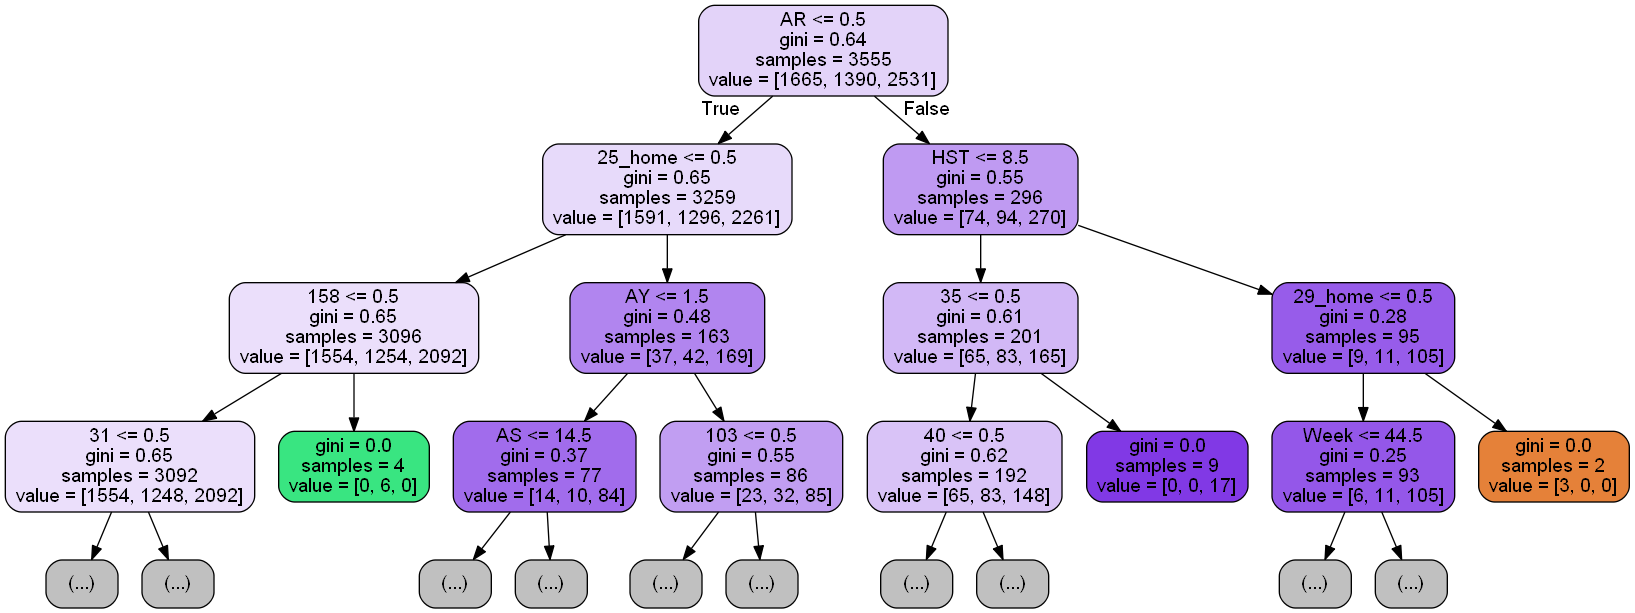

In [9]:
#Print rf tree N.B. may not work without importing graphviz, random forest images will be on GitHub
Image(filename = rf_tree_visualiser(rf, 'featureSetTree', data_filtered.columns))

### 3.1.6 Training model without Referee
<a name='section316'></a>

In [10]:
#Train model without Referee feature
data_filtered_no_ref = data_filtered.iloc[:, 0:15].join(data_filtered.iloc[:, 58:])
X_train, X_test, y_train, y_test = train_test_split(data_filtered_no_ref, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy without Referee: " + str(accuracy) + "%")
print("Difference from before: " + str(accuracy - base_accuracy) + "%")
#Ref is having negative impact so remove
data_filtered = data_filtered_no_ref

Accuracy without Referee: 56.97577276524645%
Difference from before: 0.3341687552213841%


### 3.1.7 Random Forest Tree without Referee
<a name='section317'></a>

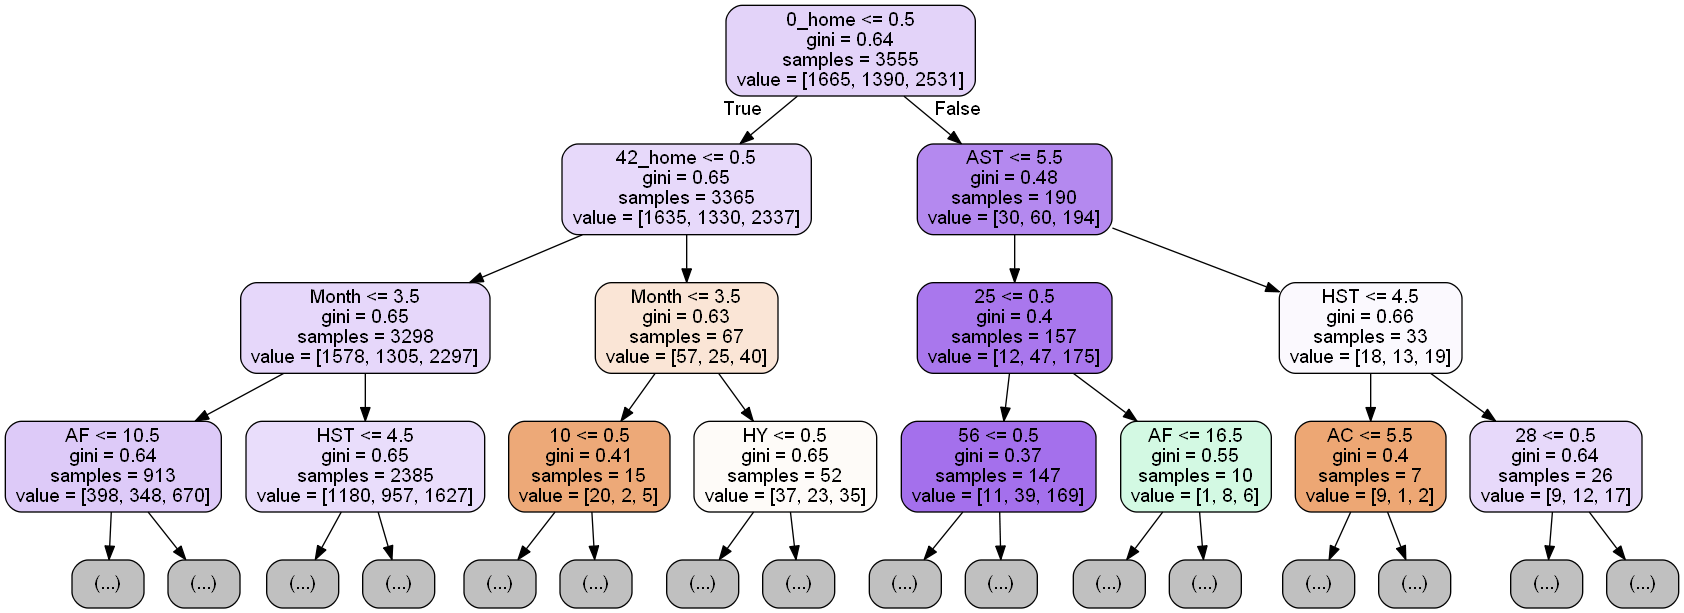

In [11]:
#Print rf tree (no ref)
Image(filename = rf_tree_visualiser(rf, 'featureSetTreeNoRef', data_filtered_no_ref.columns))

### 3.1.8 Training model without Date
<a name='section318'></a>

In [12]:
#Train model without Date feature
data_filtered_no_date = data_filtered.iloc[:, 3:]
X_train, X_test, y_train, y_test = train_test_split(data_filtered_no_date, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy without Dates: " + str(accuracy) + "%")
print("Difference from before: " + str(accuracy - base_accuracy) + "%")

Accuracy without Dates: 56.68337510442774%
Difference from before: 0.04177109440267657%


### 3.1.9 Random Forest Tree without Date
<a name='section319'></a>

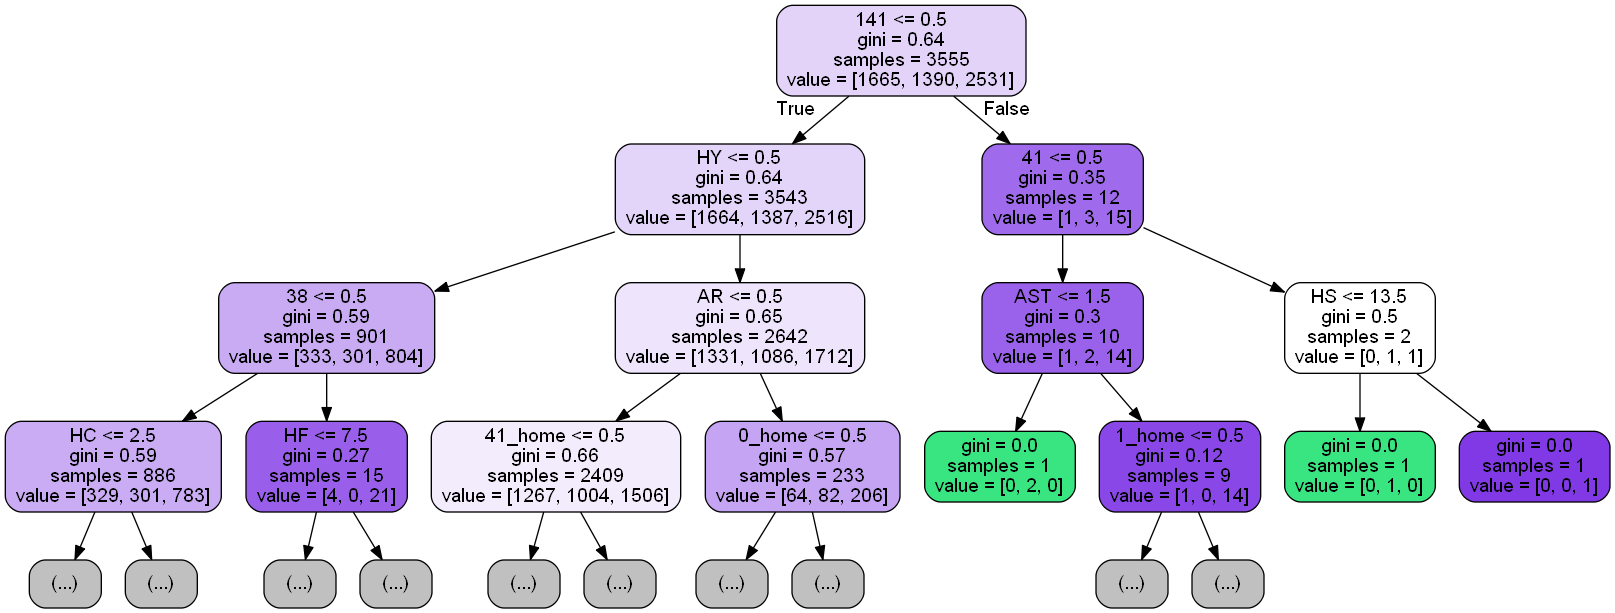

In [13]:
#Print rf tree (no dates)
Image(filename = rf_tree_visualiser(rf, 'featureSetTreeNoDate', data_filtered_no_date.columns))

### 3.1.10 Training model on only in-game stats
<a name='section3110'></a>

In [14]:
#Train model on only in-game stats to identify most important ones
data_filtered_only_game_stats = data_filtered.iloc[:, 3:15]
X_train, X_test, y_train, y_test = train_test_split(data_filtered_only_game_stats, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, all_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on all in-game stats: " + str(all_stats_accuracy) + "%")

Accuracy on all in-game stats: 55.51378446115288%


### 3.1.11 Visualising selected features
<a name='section3111'></a>

In [15]:
#Visualise and analyse initial results

#Display feature importances in descending order
feature_importances = feat_importances(X_train, rf)
print("Feature Importances: ")
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances];

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, preds))
print("\nClassification Report: ")
print(classification_report(y_test, preds))
#Important note: AF/HF rank higher than HC/AC

Feature Importances: 
Feature: HST                                 Importance: 0.12062860482667323
Feature: HS                                  Importance: 0.1095698299548388
Feature: AF                                  Importance: 0.10773279032401849
Feature: AS                                  Importance: 0.10644024578251926
Feature: HF                                  Importance: 0.10552340949204712
Feature: AST                                 Importance: 0.10340580600855823
Feature: HC                                  Importance: 0.09977784314864165
Feature: AC                                  Importance: 0.09278372110367616
Feature: AY                                  Importance: 0.06835535366590526
Feature: HY                                  Importance: 0.061179795298330265
Feature: AR                                  Importance: 0.01327811150903203
Feature: HR                                  Importance: 0.011324488885759381

Confusion Matrix: 
[[393  63 238]
 [175  73 355]
 [1

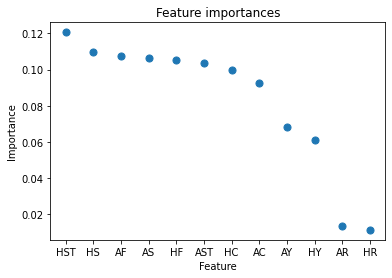

In [16]:
# Visualise feature importance
scatter(feature_importances, "Feature importances", "Feature", "Importance")

C:\Users\alisy\AppData\Local\Temp/ipykernel_51660/545697159.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  attributes = data.drop(['Date','HomeTeam', 'AwayTeam', 'Referee','FTR'],1)


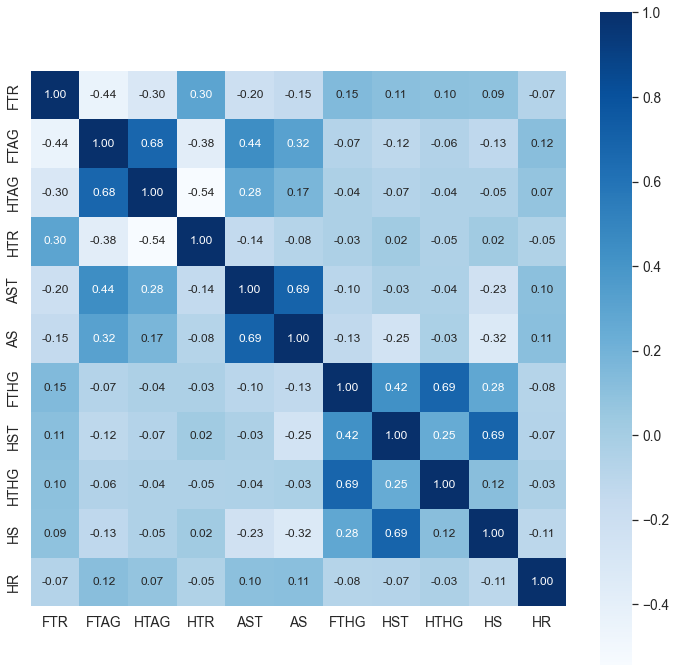

In [17]:
# plot Pearson Correlation Heatmap to see the top 10 features related to the match result FTR

def plotGraph(X_all, Y_all):

    train_data=pd.concat([X_all,Y_all],axis=1)

    #FTR correlation matrix
    plt.figure(figsize=(12,12))
    k = 11 # number of variables for heatmap
    cols = abs(train_data.astype(float).corr()).nlargest(k, 'FTR')['FTR'].index
    cm = np.corrcoef(train_data[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, cmap="Blues", yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

attributes = data.drop(['Date','HomeTeam', 'AwayTeam', 'Referee','FTR'],1)
attributes['HTR'] = attributes['HTR'].map({'H':1,'A':0,'D':2})
label = data['FTR']
label = label.map({'H':1,'A':0,'D':2})
plotGraph(attributes,label)


In [18]:
#Feature Selection
#change names and display selected features more nicely, ideally with their importance, gini impurity...
selected_feat = select_feat(X_train, y_train)
print(selected_feat)

Index(['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC'], dtype='object')


In [19]:
#Train model on selected in-game stats only
indexes = []
for feat in selected_feat:
    indexes.append(data_filtered_only_game_stats.columns.get_loc(feat))
    
data_filtered_filtered_game_stats = data_filtered_only_game_stats.iloc[:, indexes]

X_train, X_test, y_train, y_test = train_test_split(data_filtered_filtered_game_stats, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, reduced_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on reduced in-game stats: " + str(reduced_stats_accuracy) + "%")
print("Difference compared to all in-game stats: " + str(reduced_stats_accuracy - all_stats_accuracy) + "%")

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, preds))
print("\nClassification Report: ")
print(classification_report(y_test, preds))

Accuracy on reduced in-game stats: 54.92898913951546%
Difference compared to all in-game stats: -0.5847953216374222%

Confusion Matrix: 
[[379  72 243]
 [163  79 361]
 [149  91 857]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.55      0.55      0.55       694
           1       0.33      0.13      0.19       603
           2       0.59      0.78      0.67      1097

    accuracy                           0.55      2394
   macro avg       0.49      0.49      0.47      2394
weighted avg       0.51      0.55      0.51      2394



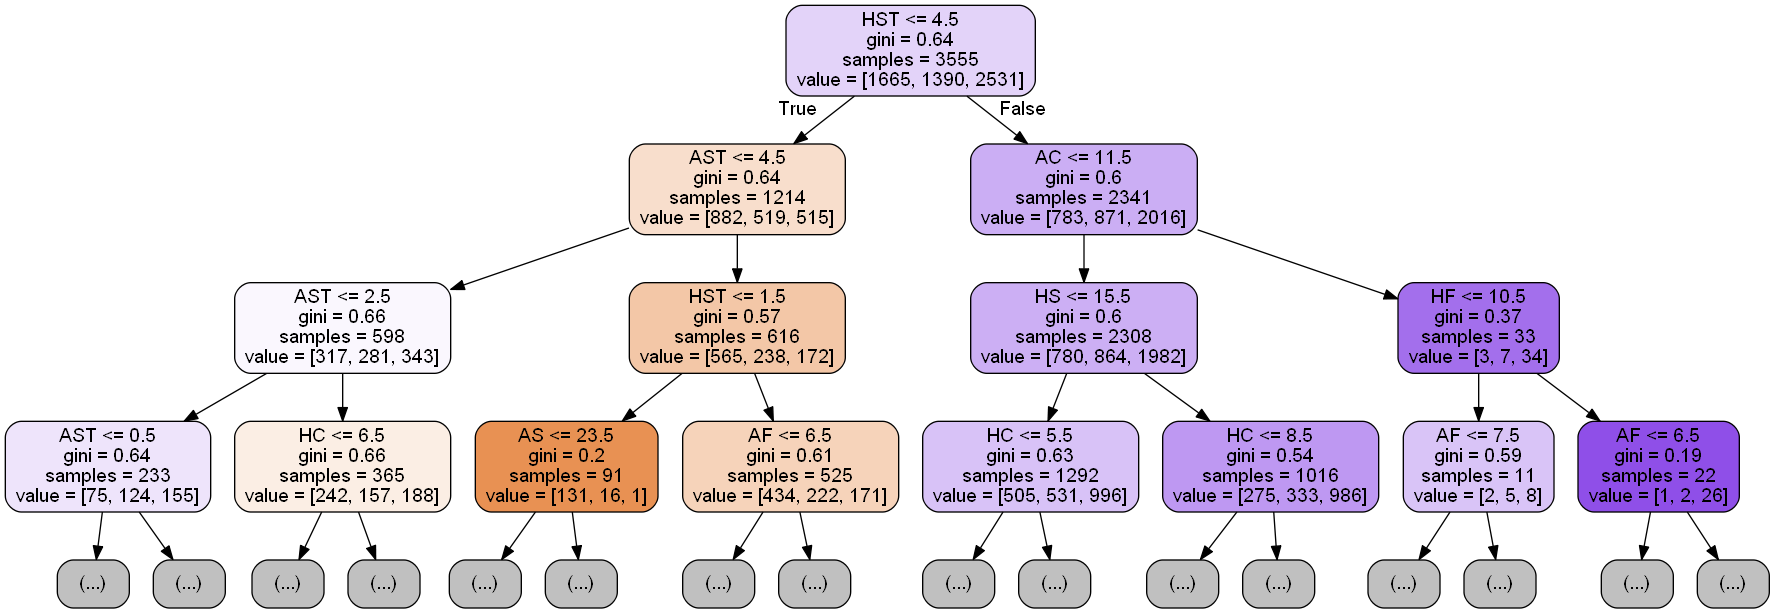

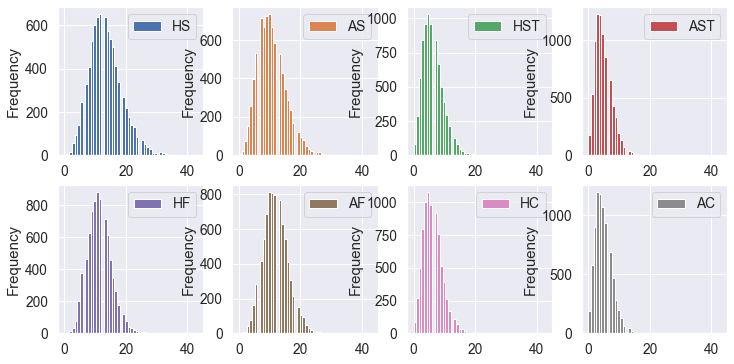

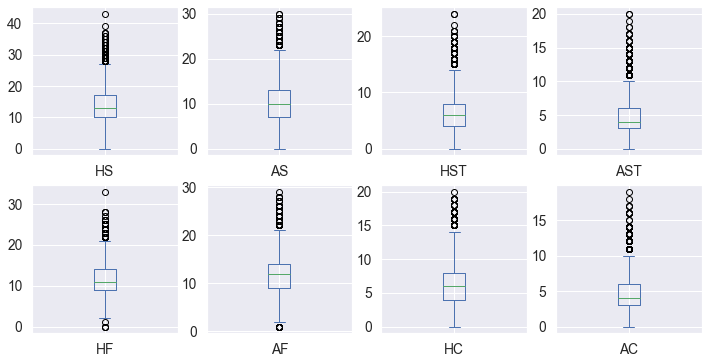

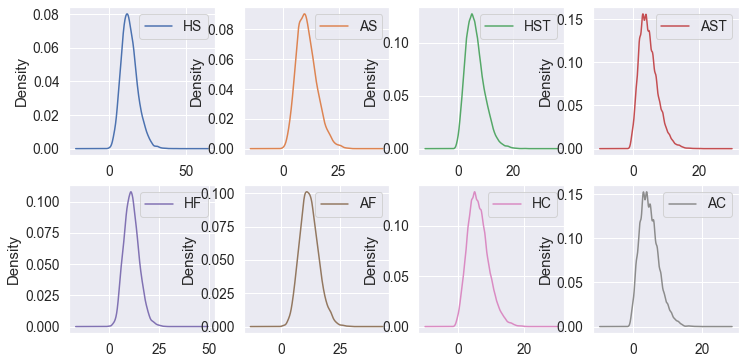

In [20]:
#Visualisation of new featureset/tree
data_filtered_filtered_game_stats.plot(kind='hist', subplots=True, sharex=False, sharey=False, bins=50, layout=(2,4), figsize=(12, 6))
data_filtered_filtered_game_stats.plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(12, 6))
data_filtered_filtered_game_stats.plot(kind='density', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(12, 6))
Image(filename = rf_tree_visualiser(rf, 'selectedFeatureSetTree', data_filtered_filtered_game_stats.columns))

In [21]:
#Produce new dataset
#Fix column names
#Restack teams and dates

#Original teams are needed to be able to compute priors
data_new = data.iloc[:, [1, 2]].join(data_filtered_filtered_game_stats)
data_new = dates_split.join(data_new)

#Stack previously removed giveaway columns
data_new = data_new.join(data.iloc[:, [3, 4, 5, 6, 7, 8]])

#Feature engineer second half goals
#Second half home goals
SHHG = np.array(data.iloc[:, [3]]) - np.array(data.iloc[:, [6]])
#Second half away goals
SHAG = np.array(data.iloc[:, [4]]) - np.array(data.iloc[:, [7]])
data_new['SHHG'] = pd.DataFrame(SHHG)
data_new['SHAG'] = pd.DataFrame(SHAG)
data_new.columns = data_new.columns.astype(str)
data_new.head()

Month  Week  Day  HomeTeam       AwayTeam  HS  AS  HST  AST  HF  AF  HC  \
0      8    33   19  Charlton       Man City  17   8   14    4  13  12   6   
1      8    33   19   Chelsea       West Ham  17  12   10    5  19  14   7   
2      8    33   19  Coventry  Middlesbrough   6  16    3    9  15  21   8   
3      8    33   19     Derby    Southampton   6  13    4    6  11  13   5   
4      8    33   19     Leeds        Everton  17  12    8    6  21  20   6   

   AC  FTHG  FTAG FTR  HTHG  HTAG HTR  SHHG  SHAG  
0   6     4     0   H     2     0   H     2     0  
1   7     4     2   H     1     0   H     3     2  
2   4     1     3   A     1     1   D     0     2  
3   8     2     2   D     1     2   A     1     0  
4   4     2     0   H     2     0   H     0     0

In [22]:
#See if second half goals have significant correlation to total goals
highest_corr = corr_matrix(data_new, "FTHG")
print("FTHG: \n" + str(highest_corr))

highest_corr = corr_matrix(data_new, "FTAG")
print("FTAG: \n" + str(highest_corr))
#Second half goals do have very strong correlation

FTHG: 
HS      0.280689
HST     0.424065
FTHG    1.000000
HTHG    0.685341
SHHG    0.768719
Name: FTHG, dtype: float64
FTAG: 
AS      0.315637
AST     0.440352
FTAG    1.000000
HTAG    0.679786
SHAG    0.775978
Name: FTAG, dtype: float64


## 3.2 Priors Feature Construction
<a name='section32'></a>

In [23]:
# From Pearson Correlation Heatmap to extract the top 10 features 
# there are two pairs of data highly correlated (see details in report), 
# so we just pick [FTHG, FTAG, HS, AS, HR, AR] from the top 10 features,
# additionally [Date, HomeTeam, AwayTeam, FTR], to derive our features.
selectedAttributes = ["Date","HomeTeam", "AwayTeam","FTR","FTHG","FTAG","HS","AS","HR","AR"]
training_data = data[selectedAttributes]

### 3.2.1 Data Cleaning
<a name='section321'></a>

In [24]:
#Derive features and remove unwanted data
def removeInvalidData(data):

    # remove data which contains None
    data.dropna(axis=0, how='any',inplace=True)

    # remove data which contains NaN, infinite or overflowed number 
    indices_to_keep = ~data.isin([np.nan, np.inf, -np.inf]).any(1)
    data = data[indices_to_keep]

    return data

#check if there are rows containing None, NaN, infinite or overflowed values
assert data.shape[0] == removeInvalidData(data).shape[0]
data = removeInvalidData(data)


In [25]:
# convert the different date formats and convert the type from str to timestamp  
def convertDate(data):
    if not isinstance(data.Date[0],str):
        return

    newDate = []
    for _, matchInfo in data.iterrows():
        if len(matchInfo.Date) == 8 :
            newDate.append(pd.to_datetime(matchInfo.Date, format="%d/%m/%y" ))
        elif len(matchInfo.Date) == 9 :
            newDate.append(pd.to_datetime(matchInfo.Date, format="%d %b %y" ))  # the date format in test data
        elif len(matchInfo.Date) == 10 :
            newDate.append(pd.to_datetime(matchInfo.Date, format="%d/%m/%Y" ))
    
    data['Date'] = pd.Series(newDate).values

    return data

# converted the date formats for later exploration and transformation
# convertDate(data_new)

### 3.2.2 Cumulative Full-time W/L Ratio
<a name='section322'></a>

In [26]:
# Computing Priors
# Calculate cumulative Full-Time win-loss ratio for Home/Away teams prior to every match
# TODO: Points-based results based on previous wins & losses 
# PHWL = Previous Home Team Win Loss Ratio
# PAWL = Previous Away Team Win Loss Ratio

def get_previousFTResults(playing_stat):
    
    # Create a dictionary with team names as keys
    teams = {}
    PHWL = []
    PAWL = []
    
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = [] #Each team gets their own list

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        
        #list of respective Home/Away team in match
        match_ht = teams[playing_stat.iloc[i].HomeTeam]
        match_at = teams[playing_stat.iloc[i].AwayTeam]
        
        #count no. of wins
        
        h_wins = Counter(match_ht)
        a_wins = Counter(match_at)
        
        #h_wins = no. of home wins
        #a_wins = no. of away wins
        h_wins = h_wins['W']
        a_wins = a_wins['W']
        
        #append W/L/D to respective teams
        
        if y[i] == 'H':
            match_ht.append('W')
            match_at.append('L')
        elif y[i] == 'A':
            match_at.append('W')
            match_ht.append('L')
        else:
            match_at.append('D')
            match_ht.append('D')
       
        h_wlRatio = h_wins / len(match_ht)
        a_wlRatio = a_wins / len(match_at)
        
        #Home/Away cumulative WL ratios prior to every match
        PHWL.append(h_wlRatio)
        PAWL.append(a_wlRatio)
        
    playing_stat.loc[:,'PHWL'] = pd.Series(PHWL)
    playing_stat.loc[:,'PAWL'] = pd.Series(PAWL)

    return playing_stat

#get_previousFTResults(data_new)

###  3.2.3 Cumulative Half-time W/L Ratio
<a name='section323'></a>

In [27]:
# Computing Priors
# Calculate cumulative Half-Time win-loss ratio for Home/Away teams prior to every match
# HHTR = Previous Home Half Time Results
# AHTR = Previous Away Half Time Results

def get_PreviousHTResults(playing_stat):
    
    # Create a dictionary with team names as keys
    teams = {}
    HHTR = []
    AHTR = []
    
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = [] #Each team gets their own list

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        
        #list of respective Home/Away team in match
        match_ht = teams[playing_stat.iloc[i].HomeTeam]
        match_at = teams[playing_stat.iloc[i].AwayTeam]
        
        #count no. of wins
        
        h_wins = Counter(match_ht)
        a_wins = Counter(match_at)
        
        #h_wins = no. of home wins
        #a_wins = no. of away wins
        h_wins = h_wins['W']
        a_wins = a_wins['W']
        
        #append W/L/D to respective teams
        
        if playing_stat.iloc[i].HTR == 'H':
            match_ht.append('W')
            match_at.append('L')
        elif playing_stat.iloc[i].HTR == 'A':
            match_at.append('W')
            match_ht.append('L')
        else:
            match_at.append('D')
            match_ht.append('D')
            
        h_wlRatio = h_wins / len(match_ht)
        a_wlRatio = a_wins / len(match_at)
       
        #Home/Away cumulative WL ratios prior to every match
        HHTR.append(h_wlRatio)
        AHTR.append(a_wlRatio)
        
    playing_stat.loc[:,'HHTR'] = pd.Series(HHTR)
    playing_stat.loc[:,'AHTR'] = pd.Series(AHTR)

    return playing_stat


#get_PreviousHTResults(data_new)

### 3.2.4 Cumulative Full-Time goals scored
<a name='section324'></a>

In [28]:
# Computing Priors
# Calculate Previous Full-Time Cumulative Goal 
# PHGS = Previous Home Goal Scored
# PAGS = Previous Away Goal Scored

def getPreviousCumulativeGoals(priorData):
    teams = {}
    PHGS = [] 
    PAGS = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        FTHG = priorData.iloc[i]['FTHG']
        FTAG = priorData.iloc[i]['FTAG']

        try:
            pcgs_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcgs_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcgs_h = 0
            pcgs_a = 0

        PHGS.append(pcgs_h)
        PAGS.append(pcgs_a)
#         print(PAGS)
#         print(PHGS)
        pcgs_h = pcgs_h + FTHG #Home team's previous goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(pcgs_h)
        pcgs_a = pcgs_a + FTAG #Away team's previous goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(pcgs_a)

    priorData.loc[:,'PHGS'] = pd.Series(PHGS)
    priorData.loc[:,'PAGS'] = pd.Series(PAGS)
    return priorData

#getPreviousCumulativeGoals(data_new)

### 3.2.5 Cumulative Half-time W/L Ratio
<a name='section325'></a>

In [29]:
# Computing Priors
# Calculate Previous Shots in the match
# PHS = Home teams previous match Shots, totaled over season
# PAS = Away teams previous match Shots, totaled over season

def getPreviousShots(priorData):
    teams = {}
    PHS = [] 
    PAS = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HS = priorData.iloc[i]['HS']
        AS = priorData.iloc[i]['AS']

        try:
            pcs_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcs_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcs_h = 0
            pcs_a = 0

        PHS.append(pcs_h)
        PAS.append(pcs_a)
        pcs_h = pcs_h + HS #Home team's previous goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(pcs_h)
        pcs_a = pcs_a + AS #Away team's previous goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(pcs_a)

    priorData.loc[:,'PHS'] = pd.Series(PHS)
    priorData.loc[:,'PAS'] = pd.Series(PAS)
    return priorData

#getPreviousShots(data_new)

### 3.2.6 Previous shots on target
<a name='section326'></a>

In [30]:
# Computing Priors
# Calculate Previous Shots on Target
# PHSOT = Home teams Previous Shots on Target, totaled over season
# PASOT = Away teams Previous Shots on Target, totaled over season

def getPreviousShotsOnTarget(priorData):
    teams = {}
    PHSOT = [] 
    PASOT = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HST = priorData.iloc[i]['HST']
        AST = priorData.iloc[i]['AST']

        try:
            pcsot_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcsot_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcsot_h = 0
            pcsot_a = 0

        PHSOT.append(pcsot_h)
        PASOT.append(pcsot_a)
        pcsot_h = pcsot_h + HST #Home team's previous goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(pcsot_h)
        pcsot_a = pcsot_a + AST #Away team's previous goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(pcsot_a)

    priorData.loc[:,'PHSOT'] = pd.Series(PHSOT)
    priorData.loc[:,'PASOT'] = pd.Series(PASOT)
    return priorData

#getPreviousShotsOnTarget(data_new)

### 3.2.7 Computing previous fouls
<a name='section327'></a>

In [31]:
# Computing Priors
# Calculate Previous Fouls
# PHTF = Home teams Previous Fouls, Totaled over season
# PATF = Away teams Previous Fouls, Totaled over season

def getPreviousTeamFouls(priorData):
    teams = {}
    PHTF = [] 
    PATF = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HF = priorData.iloc[i]['HF']
        AF = priorData.iloc[i]['AF']

        try:
            pcf_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcf_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcf_h = 0
            pcf_a = 0

        PHTF.append(pcf_h)
        PATF.append(pcf_a)
        pcf_h = pcf_h + HF #Home team's previous fouls before this match
        teams[priorData.iloc[i].HomeTeam].append(pcf_h)
        pcf_a = pcf_a + AF #Away team's previous fouls before this match
        teams[priorData.iloc[i].AwayTeam].append(pcf_a)

    priorData.loc[:,'PHTF'] = pd.Series(PHTF)
    priorData.loc[:,'PATF'] = pd.Series(PATF)
    return priorData

#getPreviousTeamFouls(data_new)

### 3.2.8 Computing previous corners
<a name='section328'></a>

In [32]:
# Computing Priors
# Calculate Previous Corners
# PHTC = Home teams Previous Corners, Totaled over season
# PATC = Away teams Previous Corners, Totaled over season

def getPreviousTeamCorners(priorData):
    teams = {}
    PHTC = [] 
    PATC = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HC = priorData.iloc[i]['HC']
        AC = priorData.iloc[i]['AC']

        try:
            pcc_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcc_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcc_h = 0
            pcc_a = 0

        PHTC.append(pcc_h)
        PATC.append(pcc_a)
        pcc_h = pcc_h + HC #Home team's previous corners before this match
        teams[priorData.iloc[i].HomeTeam].append(pcc_h)
        pcc_a = pcc_a + AC #Away team's previous corners before this match
        teams[priorData.iloc[i].AwayTeam].append(pcc_a)

    priorData.loc[:,'PHTC'] = pd.Series(PHTC)
    priorData.loc[:,'PATC'] = pd.Series(PATC)
    return priorData

#getPreviousTeamCorners(data_new)

### 3.2.9 Computing previous goals before half-time
<a name='section329'></a>

In [33]:
# Computing Priors
# Calculate Previous Goals before half time
# PHTHG = Home teams Previous Goals Before Half Time, Totaled over season
# PHTAG = Away teams Previous Goals Before Half Time, Totaled over season

def getPreviousHalfTimeGoalsScored(priorData):
    teams = {}
    PHTHG = [] 
    PHTAG = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HTHG = priorData.iloc[i]['HTHG']
        HTAG = priorData.iloc[i]['HTAG']

        try:
            pchtg_h = teams[priorData.iloc[i].HomeTeam].pop()
            pchtg_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pchtg_h = 0
            pchtg_a = 0

        PHTHG.append(pchtg_h)
        PHTAG.append(pchtg_a)
        pchtg_h = pchtg_h + HTHG #Home team's previous first half goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(pchtg_h)
        pchtg_a = pchtg_a + HTAG #Away team's previous first half goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(pchtg_a)

    priorData.loc[:,'PHTHG'] = pd.Series(PHTHG)
    priorData.loc[:,'PHTAG'] = pd.Series(PHTAG)
    return priorData

#getPreviousHalfTimeGoalsScored(data_new)

### 3.2.10 Compute previous goals after half-time
<a name='section3210'></a>

In [34]:
# Computing Priors
# Calculate Previous Second Half Time Goals in the match
# PSHHG = Previous Second Half Time Goals scored by Home team, totaled over season
# PSHAG = Previous Second Half Time Goals scored by Away team, totaled over season

def getPreviousSecondHalfGoals(priorData):
    teams = {}
    PSHHG = [] 
    PSHAG = []   
    
    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
                
        FTHG = priorData.iloc[i]['FTHG']
        FTAG = priorData.iloc[i]['FTAG']
        HTHG = priorData.iloc[i]['HTHG']
        HTAG = priorData.iloc[i]['HTAG']

        try:
            shg_h = teams[priorData.iloc[i].HomeTeam].pop()
            shg_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            shg_h = 0
            shg_a = 0

        PSHHG.append(shg_h)
        PSHAG.append(shg_a)
        shg_h = shg_h + (FTHG - HTHG) #Home team's previous second half goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(shg_h)
        shg_a = shg_a + (FTAG - HTAG) #Away team's previous second half goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(shg_a)

    priorData.loc[:,'PSHHG'] = pd.Series(PSHHG)
    priorData.loc[:,'PSHAG'] = pd.Series(PSHAG)
    return priorData

#getPreviousSecondHalfGoals(data_new)

### 3.2.11 Computing previous goals conceded before half-time
<a name='section3211'></a>

In [35]:
# Computing Priors
# Calculate previous goals conceded before half-time
# PHTHGC = Home Team Previous Goals Conceded Before Half Time, totaled over season
# PHTAGC = Away Team Previous Goals Conceded Before Half Time, Totaled over season

def getPreviousHalfTimeGoalConceded(priorData):
    teams = {}
    PHTHGC = [] 
    PHTAGC = []   
    
    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
                      
        HTHG = priorData.iloc[i]['HTHG']
        HTAG = priorData.iloc[i]['HTAG']

        try:
            phtgc_h = teams[priorData.iloc[i].HomeTeam].pop()
            phtgc_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            phtgc_h = 0
            phtgc_a = 0

        PHTHGC.append(phtgc_h)
        PHTAGC.append(phtgc_a)
        phtgc_h = phtgc_h + HTAG #Home team's previous half time goals conceded before this match
        teams[priorData.iloc[i].HomeTeam].append(phtgc_h)
        phtgc_a = phtgc_a + HTHG #Away team's previous half time goals conceded before this match
        teams[priorData.iloc[i].AwayTeam].append(phtgc_a)

    priorData.loc[:,'PHTHGC'] = pd.Series(PHTHGC)
    priorData.loc[:,'PHTAGC'] = pd.Series(PHTAGC)
    return priorData

#getPreviousHalfTimeGoalConceded(data_new)

### 3.2.12 Computing previous goals conceded after half-time
<a name='section3212'></a>

In [36]:
# Computing Priors
# Calculate previous goals conceded after half-time
# PSHHGC = Previous second half home team goals conceded, totaled over season
# PSHAGC = Previous second half away team goals conceded, totaled over season

def getPreviousSecondHalfGoalConceded(priorData):
    teams = {}
    PSHHGC = [] 
    PSHAGC = []   
    
    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
  
        FTHG = priorData.iloc[i]['FTHG']
        FTAG = priorData.iloc[i]['FTAG']   
        HTHG = priorData.iloc[i]['HTHG']
        HTAG = priorData.iloc[i]['HTAG']

        try:
            pshhgc_h = teams[priorData.iloc[i].HomeTeam].pop()
            pshhgc_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pshhgc_h = 0
            pshhgc_a = 0

        PSHHGC.append(pshhgc_h)
        PSHAGC.append(pshhgc_a)
        pshhgc_h = pshhgc_h + (FTAG - HTAG) #Home team's previous half time goals conceded before this match
        teams[priorData.iloc[i].HomeTeam].append(pshhgc_h)
        pshhgc_a = pshhgc_a + (FTHG - HTHG) #Away team's previous half time goals conceded before this match
        teams[priorData.iloc[i].AwayTeam].append(pshhgc_a)

    priorData.loc[:,'PSHHGC'] = pd.Series(PSHHGC)
    priorData.loc[:,'PSHAGC'] = pd.Series(PSHAGC)
    return priorData

#getPreviousSecondHalfGoalConceded(data_new)

### 3.2.13 Matches Played
<a name='section3213'></a>

In [37]:
# Computing Priors 
# Calculate previous goals conceded after half-time
# PMPH = Previous total matches played for home team
# PMPA = Previous total matches played for away team
def getPreviousMatchesPlayed(priorData):
    teams = {}
    PMPH = [] 
    PMPA = []   
    
    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        try:
            pmp_h = teams[priorData.iloc[i].HomeTeam].pop()
            pmp_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pmp_h = 0
            pmp_a = 0

        PMPH.append(pmp_h)
        PMPA.append(pmp_a)
        pmp_h = pmp_h + 1 #Home team's previous number matches played
        teams[priorData.iloc[i].HomeTeam].append(pmp_h)
        pmp_a = pmp_a + 1 #Away team's previous number matches played
        teams[priorData.iloc[i].AwayTeam].append(pmp_a)

    priorData.loc[:,'PMPH'] = pd.Series(PMPH)
    priorData.loc[:,'PMPA'] = pd.Series(PMPA)
    return priorData

print(getPreviousMatchesPlayed(data_new))

      Month  Week  Day          HomeTeam        AwayTeam  HS  AS  HST  AST  \
0         8    33   19          Charlton        Man City  17   8   14    4   
1         8    33   19           Chelsea        West Ham  17  12   10    5   
2         8    33   19          Coventry   Middlesbrough   6  16    3    9   
3         8    33   19             Derby     Southampton   6  13    4    6   
4         8    33   19             Leeds         Everton  17  12    8    6   
...     ...   ...  ...               ...             ...  ..  ..  ...  ...   
7975      5    20   23         Liverpool  Crystal Palace  19   5    5    4   
7976      5    20   23          Man City         Everton  21   8   11    3   
7977      5    20   23  Sheffield United         Burnley  12  10    3    3   
7978      5    20   23          West Ham     Southampton  14  17    7    5   
7979      5    20   23            Wolves      Man United  14   9    4    4   

      HF  AF  HC  AC  FTHG  FTAG FTR  HTHG  HTAG HTR  SHHG  SHA

## 3.3 Additional Features
<a name='section33'></a>

### 3.3.1 Distance Travelled for Away Teams
<a name='section331'></a>

In [38]:
# DIS
# The positionalData contains the latitude and longitude of teams
def getDistance(priorData):
  array = []
  for x in priorData.iterrows():
   
    home_lat = (positionalData.loc[positionalData['Team'] == x[1].HomeTeam]).Latitude
    home_long = (positionalData.loc[positionalData['Team'] == x[1].HomeTeam]).Longitude
    home_location = (np.float32(home_lat), np.float32(home_long))
    
    away_lat = (positionalData.loc[positionalData['Team'] == x[1].AwayTeam]).Latitude
   
    away_long = (positionalData.loc[positionalData['Team'] == x[1].AwayTeam]).Longitude
    away_location = (np.float32(away_lat), np.float32(away_long))
    array.append(np.float32(geodesic(home_location, away_location).km))
  
  
  DIS = pd.Series(array)
  priorData.loc[:,'DIS'] = DIS

  return priorData

### 3.3.2 Average shots on goal in the past 3 matches
<a name='section332'></a>

In [39]:
# Average shots on goal for the past 3 matches
# HAS, AAS
def getPreviousShotOnGoal_3(priorData):
    teams = {}
    HAS = [] 
    AAS = []   
    
    for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = deque([None, None, None]) #[3rd, 2nd, latest priorData]
            
    # for each match
    for i in range(len(priorData)):

            
        try:
            as_h = np.mean(teams[priorData.iloc[i].HomeTeam])
            as_a = np.mean(teams[priorData.iloc[i].AwayTeam])
        except:
            as_h = None
            as_a = None

        HAS.append(as_h)
        AAS.append(as_a)

        teams[priorData.iloc[i].HomeTeam].popleft()
        teams[priorData.iloc[i].HomeTeam].append(priorData.iloc[i].HS)

        teams[priorData.iloc[i].AwayTeam].popleft()
        teams[priorData.iloc[i].AwayTeam].append(priorData.iloc[i].AS)

    priorData.loc[:,'HAS'] = pd.Series(HAS)
    priorData.loc[:,'AAS'] = pd.Series(AAS)

    return priorData

#getPreviousShotOnGoal_3(data_new)

### 3.3.3 WL Performance of past 3 matches
<a name='section333'></a>

In [40]:
# Performance of Home-Away teams in past 3 matches
# HM1, AM1, HM2, AM2, HM3, AM3
def getPerformanceOfLast3Matches(priorData):
    HM1 = []    # performance of the last match of home team
    AM1 = []    # performance of the last match of away team

    HM2 = []    # performance of the 2nd last match of home team
    AM2 = []

    HM3 = []    # performance of the 3rd last match of home team
    AM3 = []

    teams = {}
    
    for name in priorData.groupby('HomeTeam').mean().T.columns:
               teams[name] = deque([None, None, None])  #[3rd, 2nd, latest priorData]

    for i in range(len(priorData)):
        

        HM3.append(teams[priorData.iloc[i].HomeTeam].popleft())
        AM3.append(teams[priorData.iloc[i].AwayTeam].popleft())
        HM2.append(teams[priorData.iloc[i].HomeTeam][0])
        AM2.append(teams[priorData.iloc[i].AwayTeam][0])
        HM1.append(teams[priorData.iloc[i].HomeTeam][1])
        AM1.append(teams[priorData.iloc[i].AwayTeam][1])

        if priorData.iloc[i].FTR == 'H':
            teams[priorData.iloc[i].HomeTeam].append('W')
            teams[priorData.iloc[i].AwayTeam].append('L')
        elif priorData.iloc[i].FTR == 'A':
            teams[priorData.iloc[i].AwayTeam].append('W')
            teams[priorData.iloc[i].HomeTeam].append('L')
        else:
            teams[priorData.iloc[i].AwayTeam].append('D')
            teams[priorData.iloc[i].HomeTeam].append('D')

    priorData.loc[:,'HM1'] = HM1
    priorData.loc[:,'AM1'] = AM1
    priorData.loc[:,'HM2'] = HM2
    priorData.loc[:,'AM2'] = AM2
    priorData.loc[:,'HM3'] = HM3
    priorData.loc[:,'AM3'] = AM3

    return priorData

#print(getPerformanceOfLast3Matches(data_new)

### 3.3.4 Cumulative Full Time Goal Difference
<a name='section334'></a>

In [41]:
# Computing Priors
# Calculate cumulative Full-Time goal different for Home/Away teams prior to every match
# HCGD = Home Cumulative Goal Difference
# ACGD = Away Cumulative Goal Difference
def getCumulativeGoalsDiff(priorData):
    teams = {}
    HCGD = [] 
    ACGD = []   

    # for each match
    for i in range(len(priorData)):
        # as the result in 3.2.1 shows that the number of matchese per season is always the same, so here we simply use i%380==0 to check if it is a new season and to initialize the feature.
        if (i % 380 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = []

        FTHG = priorData.iloc[i]['FTHG']
        FTAG = priorData.iloc[i]['FTAG']

        try:
            cgd_h = teams[priorData.iloc[i].HomeTeam].pop()
            cgd_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            cgd_h = 0
            cgd_a = 0

        HCGD.append(cgd_h)
        ACGD.append(cgd_a)
        cgd_h = cgd_h + FTHG - FTAG
        teams[priorData.iloc[i].HomeTeam].append(cgd_h)
        cgd_a = cgd_a + FTAG - FTHG
        teams[priorData.iloc[i].AwayTeam].append(cgd_a)

    priorData.loc[:,'HCGD'] = pd.Series(HCGD)
    priorData.loc[:,'ACGD'] = pd.Series(ACGD)

    return priorData

#getCumulativeGoalsDiff(data_new)

### 3.3.5 Goalkeeper Stats
<a name='section335'></a>

In [42]:
# # Goalkeeping stats for each team for season starting 2008/2009, ending at present (2021/2020)
# def getGK(data, GKData):
    
#     teams = {}
#     HSaveP = [] #Save percentage (Home team)
#     HCSP   = [] #Clean sheet percentage
#     ASaveP = [] 
#     ACSP   = [] 
    
#     ## Split data into seasons
#     data2008 = data.iloc[:379,:] # 2008-2009 season
#     data2009 = data.iloc[380:759,:]
#     data2010 = data.iloc[760:1139,:]
#     data2011 = data.iloc[1140:1519,:]
#     data2012 = data.iloc[1520:1899,:]
#     data2013 = data.iloc[1900:2279,:]
#     data2014 = data.iloc[2280:2659,:]
#     data2015 = data.iloc[2660:3039,:]
#     data2016 = data.iloc[3040:3419,:]
#     data2017 = data.iloc[3420:3799,:]
#     data2018 = data.iloc[3800:4179,:]
#     data2019 = data.iloc[4180:4559,:]
#     data2020 = data.iloc[4560:4939,:] #2020-2021 season
    
#     GKData2008 = GKData.iloc[:19,:] # 2008-2009 season
#     GKData2009 = GKData.iloc[20:39,:]
#     GKData2010 = GKData.iloc[40:59,:]
#     GKData2011 = GKData.iloc[60:79,:]
#     GKData2012 = GKData.iloc[80:99,:]
#     GKData2013 = GKData.iloc[100:119,:]
#     GKData2014 = GKData.iloc[120:139,:]
#     GKData2015 = GKData.iloc[140:159,:]
#     GKData2016 = GKData.iloc[160:179,:]
#     GKData2017 = GKData.iloc[180:199,:]
#     GKData2018 = GKData.iloc[200:219,:]
#     GKData2019 = GKData.iloc[220:239,:]
#     GKData2020 = GKData.iloc[240:259,:] #2020-2021 season

#     for i in data.groupby('HomeTeam').mean().T.columns: #for 2009 season
#             teams[i] = [] #Each team gets their own list

#     # the value corresponding to keys is a list containing the match result

#     for i in range(len(GKData2008)): # i think swap this for data instead and figure how to go through gkdata 1 at a time
#         if GKData2008.iloc[i].Squad == data2008.iloc[i].HomeTeam:
#             teams[data2008.iloc[i].HomeTeam].append(GKData2008[["SavePercentage","CSPercentage"]].iloc[i])
#     print(teams)
#     print(len(GKData2008))
        
# #         SAVEP = teams[data2009.iloc[i].HomeTeam] #use 2008 season gk data
# #         CSP = teams[data2009.iloc[i].HomeTeam]

# #         HSaveP.append(SAVEP)
# #         HCSP.append(CSP)
# #         ASaveP.append(SAVEP)
# #         ACSP.append(CSP)
        
# #         teams[data2009.iloc[i].HomeTeam].append(SAVEP)
# #         teams[data2009.iloc[i].HomeTeam].append(CSP)
# #         teams[data2009.iloc[i].AwayTeam].append(SAVEP)
# #         teams[data2009.iloc[i].AwayTeam].append(CSP)

# #         data2009.loc[:,'HSaveP'] = pd.Series(HSaveP)
# #         data2009.loc[:,'HCSP'] = pd.Series(HCSP)
# #         data2009.loc[:,'ASaveP'] = pd.Series(ASaveP)
# #         data2009.loc[:,'ACSP'] = pd.Series(ACSP)
#     return data2009

# getGK(data, GKData)

### Priors - extra features pulled

In [43]:
def add_pickled_to_df(df,filename,column):
    matrix = pd.read_pickle(filename)
    matrix[2008] = np.NaN
#     print(matrix)
    difference = []
    for i in range(0,len(data_new)):
    #     print(ratings_matrix["mean"].loc[data_new["HomeTeam"].iloc[i]])
        if pd.isnull(matrix[year[i]].loc[df["HomeTeam"].iloc[i]]) or pd.isnull(matrix[year[i]].loc[df["AwayTeam"].iloc[i]]):
            difference.append(np.nan)
            
        else:
            difference.append(matrix[year[i]].loc[df["HomeTeam"].iloc[i]]-matrix[year[i]].loc[df["AwayTeam"].iloc[i]])

#     for i in range(0,len(difference)):
#         if difference[i]<-0.1:
#             difference[i]='A'
#         elif difference[i]>0.1:
#             difference[i]='H'
#         else:
#             difference[i]='D'

    df[column]=difference
    return df

### We have decided not to include these scraped features due to the many missing values without a reliable way to impute them.

In [44]:
# import glob
# files = glob.glob("./Pickles/*")
# for file in files:
#     name = file.split("\\")[-1].split(".")[0].replace("DF","")
#     data_new = add_pickled_to_df(data_new,file,name)

# data_new

## 3.4 Derive Priors
<a name='section34'></a>

In [45]:
def DerivePriors(priorData):
    #get_previousFTResults(priorData) # dont want Full time results in the test data
    get_PreviousHTResults(priorData)
    getPreviousCumulativeGoals(priorData)
    getPreviousShots(priorData)
    getPreviousShotsOnTarget(priorData)
    getPreviousTeamFouls(priorData)
    getPreviousTeamCorners(priorData)
    getPreviousHalfTimeGoalsScored(priorData)
    getPreviousSecondHalfGoals(priorData)
    getPreviousHalfTimeGoalConceded(priorData)
    getPreviousSecondHalfGoalConceded(priorData)
    getPreviousMatchesPlayed(priorData)
    getDistance(priorData)
    getPreviousShotOnGoal_3(priorData)
    getPerformanceOfLast3Matches(priorData)
    getCumulativeGoalsDiff(priorData)
    #getGK(data, GKData)
    return priorData

In [46]:
## Remove First Initial Season
data_new = DerivePriors(data_new).iloc[380:] #chop off first season 
y=np.delete(y,slice(0,380),axis=0)
data_new.reset_index(drop=True, inplace=True)
data_new 

Month  Week  Day          HomeTeam        AwayTeam  HS  AS  HST  AST  \
0         8    33   18          Charlton         Everton   8  12    4    9   
1         8    33   18             Derby       Blackburn   7  14    3    4   
2         8    33   18             Leeds     Southampton  16  11    6    6   
3         8    33   18         Leicester          Bolton   6  18    1    8   
4         8    33   18         Liverpool        West Ham   9   3    6    3   
...     ...   ...  ...               ...             ...  ..  ..  ...  ...   
7595      5    20   23         Liverpool  Crystal Palace  19   5    5    4   
7596      5    20   23          Man City         Everton  21   8   11    3   
7597      5    20   23  Sheffield United         Burnley  12  10    3    3   
7598      5    20   23          West Ham     Southampton  14  17    7    5   
7599      5    20   23            Wolves      Man United  14   9    4    4   

      HF  AF  HC  AC  FTHG  FTAG FTR  HTHG  HTAG HTR  SHHG  SHAG  PMPH  PMPA  \
0     15  17   4   4     1     2   A     0     0   D     1     2    38    38   
1     14  15   4  10     2     1   H     1     0   H     1     1    38     0   
2     16  24  10   3     2     0   H     0     0   D     2     0    38    38   
3     21  17   3   5     0     5   A     0     4   A     0     1    38     0   
4     13  12   5   3     2     1   H     1     1   D     1     0    38    38   
...   ..  ..  ..  ..   ...   ...  ..   ...   ...  ..   ...   ...   ...   ...   
7595  10   8  14   1     2     0   H     1     0   H     1     0   797   341   
7596   8  10   7   5     5     0   H     2     0   H     3     0   759   797   
7597  11   1   8   9     1     0   H     1     0   H     0     0   113   265   
7598   5   9   2   3     3     0   H     2     0   H     1     0   683   531   
7599  14   3   6   2     1     2   A     1     2   A     0     0   265   797   

          HHTR      AHTR  PHGS  PAGS    PHS    PAS  PHSOT  PASOT  PHTF  PATF  \
0     0.358974  0.179487    50    45    373    394    217    195   467   558   
1     0.307692  0.000000    37     0    305      0    141      0   529     0   
2     0.307692  0.205128    64    40    475    414    228    174   589   509   
3     0.179487  0.000000    39     0    326      0    159      0   426     0   
4     0.384615  0.205128    71    45    488    475    249    229   473   473   
...        ...       ...   ...   ...    ...    ...    ...    ...   ...   ...   
7595  0.408521  0.216374  1420   378  12013   3784   5550   1298  8540  4028   
7596  0.418421  0.281955  1374  1059  10879   9446   4969   4393  8536  9646   
7597  0.192982  0.203008    90   266   1069   2725    413    976  1313  2770   
7598  0.273392  0.259398   845   655   7904   6486   3419   2620  7829  6334   
7599  0.191729  0.461153   289  1503   2938  11570   1279   5668  2954  8971   

      PHTC  PATC  PHTHG  PHTAG  PSHHG  PSHAG  PHTHGC  PHTAGC  PSHHGC  PSHAGC  \
0      213   203     27     19     23     26      21      26      36      33   
1      159     0     20      0     17      0      25       0      34       0   
2      270   211     28     16     36     24      26      18      17      30   
3      174     0     18      0     21      0      20       0      31       0   
4      243   213     28     18     43     27      18      28      21      22   
...    ...   ...    ...    ...    ...    ...     ...     ...     ...     ...   
7595  5153  1732    621    146    799    232     344     206     438     291   
7596  4890  4411    634    470    740    589     353     427     467     561   
7597   555  1140     39    121     51    145      69     188      88     213   
7598  3541  2858    380    299    465    356     447     346     562     387   
7599  1423  5039    112    684    177    819     211     322     206     402   

              DIS        HAS        AAS HM1   AM1 HM2   AM2 HM3   AM3  HCGD  \
0     5929.836426  13.000000  15.000000   L     D   L     L   W     W     0   
1      114.101906        NaN

### 3.5 Final Data Preprocessing
<a name='section35'></a>

In [47]:
#Final data preprocessing

# TODO:
# Implement dates using trig - done
# Add one hot encoded teams - done
# Compute custom features using priors (goals/shots on target, shots on target / total shots, home team fouls / away team fouls)
# PHGS/PHSOT, PAGS/PASOT & PHSOT/PHS, PASOT/PAS & PHTF/PATF - done
# Implement scaling but don't apply just yet - done
# Apply PCA - done

dates = data_new.iloc[:, 0:3]
month_sin = transformation(dates["Month"])[0]
month_cos = transformation(dates["Month"])[1]
week_sin = transformation(dates["Week"])[0]
week_cos = transformation(dates["Week"])[1]
day_sin = transformation(dates["Day"])[0]
day_cos = transformation(dates["Day"])[1]

teams = pd.DataFrame(home_t.toarray()).add_prefix("home_").join(pd.DataFrame(away_t.toarray()).add_prefix("away_"))

# Select only columns that contain priors, can't use in-game stats to predict the future
priors = data_new.iloc[:, 21:44]

# PHGS_PHSOT is ratio of home goals to home shots on target
PHGS_PHSOT = np.where(priors["PHSOT"] != 0, priors["PHGS"]/priors["PHSOT"], 0)
# PHGS_PHSOT is ratio of away goals to away shots on target
PAGS_PASOT = np.where(priors["PASOT"] != 0, priors["PAGS"]/priors["PASOT"], 0)
# PHSOT_PHS is ratio of home shots on target to home shots
PHSOT_PHS = np.where(priors["PHS"] != 0, priors["PHSOT"]/ (priors["PHS"] + priors["PHSOT"]), 0)
# PASOT_PAS is ratio of away shots on target to away shots
PASOT_PAS = np.where(priors["PAS"] != 0, priors["PASOT"]/ (priors["PAS"] + priors["PASOT"]), 0)
# PHTF_PATF is ratio of home fouls to away fouls
PHTF_PATF = np.where(priors["PATF"] != 0, priors["PHTF"]/priors["PATF"], 0)

# Building final dataset
X = pd.DataFrame()
X["month_cos"] = month_cos
X["month_sin"] = month_sin
X["week_cos"] = week_cos
X["week_sin"] = week_sin
X["day_cos"] = day_cos
X["day_sin"] = day_sin
X = X.join(teams).join(priors)
X["PHGS_PHSOT"] = PHGS_PHSOT.tolist()
X["PAGS_PASOT"] = PAGS_PASOT.tolist()
X["PHSOT_PHS"] = PHSOT_PHS.tolist()
X["PASOT_PAS"] = PASOT_PAS.tolist()
X["PHTF_PATF"] = PHTF_PATF.tolist()
X

month_cos  month_sin  week_cos  week_sin   day_cos   day_sin  home_0  \
0     -0.500000  -0.866025 -0.717507 -0.696551 -0.874347 -0.485302     0.0   
1     -0.500000  -0.866025 -0.717507 -0.696551 -0.874347 -0.485302     0.0   
2     -0.500000  -0.866025 -0.717507 -0.696551 -0.874347 -0.485302     0.0   
3     -0.500000  -0.866025 -0.717507 -0.696551 -0.874347 -0.485302     0.0   
4     -0.500000  -0.866025 -0.717507 -0.696551 -0.874347 -0.485302     0.0   
...         ...        ...       ...       ...       ...       ...     ...   
7595  -0.866025   0.500000 -0.717507  0.696551 -0.050649 -0.998717     0.0   
7596  -0.866025   0.500000 -0.717507  0.696551 -0.050649 -0.998717     0.0   
7597  -0.866025   0.500000 -0.717507  0.696551 -0.050649 -0.998717     0.0   
7598  -0.866025   0.500000 -0.717507  0.696551 -0.050649 -0.998717     0.0   
7599  -0.866025   0.500000 -0.717507  0.696551 -0.050649 -0.998717     0.0   

      home_1  home_2  home_3  home_4  home_5  home_6  home_7  home_8  home_9  \
0        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
7595     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7596     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7597     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7598     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7599     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      home_10  home_11  home_12  home_13  home_14  home_15  home_16  home_17  \
0         0.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0   
1         0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
2         0.0      0.0      0.0      1.0      0.0      0.0      0.0      0.0   
3         0.0      0.0      0.0      0.0      0.0      1.0      0.0      0.0   
4         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
7595      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7596      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7597      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7598      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7599      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

      home_18  home_19  home_20  home_21  home_22  home_23  home_24  home_25  \
0         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4         0.0      0.0      0.0      1.0      0.0      0.0      0.0      0.0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
7595      0.0      0.0      0.0      0.0      1.0      0.0      0.0      0.0   
7596      0.0      0.0      0.0      0.0      0.0      0.0      1.0      0.0   
7597      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7598      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7599      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

      home_26  home_27  home_28  home_29  home_30  home_31  home_32  home_33  \
0         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1         0.0      0.0    

### 3.5.1 Split Data
<a name='section351'></a>

In [61]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

y_train = np.array(y_train).reshape(len(y_train))
y_val = np.array(y_val).reshape(len(y_val))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)


from tensorflow import keras
y_train_categorical = keras.utils.to_categorical(y_train)
y_val_categorical = keras.utils.to_categorical(y_val)
y_test_categorical = keras.utils.to_categorical(y_test)

In [49]:
#try without our custom features
rf, preds, all_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on all in-game stats: " + str(all_stats_accuracy) + "%")

feature_importances = feat_importances(X_train, rf)
print("Feature Importances: ")
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances];

Accuracy on all in-game stats: 47.89473684210526%
Feature Importances: 
Feature: AHTR                                Importance: 0.04079691674434672
Feature: HHTR                                Importance: 0.038440396878765506
Feature: PAGS_PASOT                          Importance: 0.03291120935792482
Feature: PHGS_PHSOT                          Importance: 0.03252775660738477
Feature: PHSOT_PHS                           Importance: 0.03123204207301899
Feature: DIS                                 Importance: 0.030028998872474556
Feature: PASOT_PAS                           Importance: 0.029682227845421304
Feature: PHTF_PATF                           Importance: 0.028699122755288978
Feature: PHTAG                               Importance: 0.028291044905542413
Feature: PSHHG                               Importance: 0.028106852478190128
Feature: PSHAG                               Importance: 0.027934441589256134
Feature: PHTHG                               Importance: 0.027367412646157

### 3.6 Scale data
<a name='section36'></a>

In [50]:
# Not sure if data needs to be scaled so just gonna leave this here
scaler = StandardScaler().fit(X_train.iloc[:, 92:])
X_train_scaled = scaler.transform(X_train.iloc[:, 92:])
X_test_scaled = scaler.transform(X_test.iloc[:, 92:])
X_val_scaled = scaler.transform(X_val.iloc[:, 92:])

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_val = pd.DataFrame(X_val)

X_train = np.array(X_train.iloc[:, 0:92])
X_test = np.array(X_test.iloc[:, 0:92])
X_val = np.array(X_val.iloc[:, 0:92])

X_train_scaled = np.hstack((X_train, X_train_scaled))
X_test_scaled = np.hstack((X_test, X_test_scaled))
X_val_scaled = np.hstack((X_val, X_val_scaled))

# PCA
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# pca = PCA(0.95)
# pca.fit(X_train_scaled)
# X_train = pca.transform(X_train_scaled)
# X_test = pca.transform(X_test_scaled)

# pca = PCA(n_components=50)
# X = pca.fit_transform(X_scaled)

# from sklearn.manifold import TSNE
# X = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(X)

# from sklearn.manifold import MDS
# embedding = MDS(n_components=2)
# X = embedding.fit_transform(X) -> took way too long

# from sklearn.manifold import Isomap
# embedding = Isomap(n_components=2)
# X = embedding.fit_transform(X) -> gave terrible results

# import umap.umap_ as umap
# reducer = umap.UMAP(random_state=42,n_components=15)
# X = reducer.fit_transform(X_scaled) -> requires outdated numpy

from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=15, kernel='rbf')
kpca.fit(X_train_scaled)
X_train = kpca.transform(X_train_scaled)
X_test = kpca.transform(X_test_scaled)
X_val = kpca.transform(X_val_scaled)
#tune hyperparams for this -> gamma

# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# clf = LinearDiscriminantAnalysis()
# clf.fit(X_train_scaled, y_train)
# X_train = clf.transform(X_train_scaled)
# X_test = clf.transform(X_test_scaled)

# from sklearn.manifold import TSNE
# X = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

#consider combos of these eg pca then lda

In [51]:
#Reshaping data for RNN, LSTM, GRU
X_train_test = np.reshape(X_train, (532, 10, X_train.shape[1]))

y_train_test = np.reshape(y_train_categorical, (532, 10, 3))

y_train_test_cnn = np.array(y_train_categorical).reshape(-1, 1, y_train_categorical.shape[1])

X_val_test = np.reshape(X_val, (114, 10, X_val.shape[1]))

y_val_categorical_test = np.reshape(y_val_categorical, (114, 10, 3))

y_val_test_cnn = np.array(y_val_categorical).reshape(-1, 1, y_val_categorical.shape[1])

X_test_test = X_test.reshape(114, 10, X_test.shape[1])

## 4. Methodology Overview
<a name='section4'></a>

## 5. Model Training & Validation
<a name='section5'></a>

In [ ]:
#Functions to remove warning to see clearer result
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning


warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

#Import for optuna and cv
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

### 5.1 Base Models
<a name='section51'></a>

#### 5.1.1 Gaussian Naive Bayes
<a name='section511'></a>

In [ ]:
## TODO: Implement into pipeline ##
# Some general comments:
# Gaussian NB is most suitable for non-categorical classification
# Based on diagram above (gaussian distributed density plots) the features we use are gaussian distributed however 
# the teams are not actually gaussian distributed 
# And the features we use are not conditionally independent as the statistics arent independent (e.g. shots affect
# shots on target etc.)
# Therefore we expect that the prediction will not be accurate and naives bayes is not suitable

#prove calculations and results later



from sklearn.naive_bayes import GaussianNB


gnb = GaussianNB()
y_gnb = gnb.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_gnb)
 

#Smoothing parameter scaling

cv_method = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
gnb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, cv=cv_method,verbose=1, scoring='accuracy',n_jobs=-1)
y_gnb = gnb.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_gnb)
 

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_gnb), ": is the accuracy score gnb")

#### 5.1.2 Generic SVM
<a name='section512'></a>

In [ ]:
#Using generic SVM to estimate
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC, SVR

# gammas = np.power(2, np.linspace(-15, 3, 10))
# accuracy_validation = np.empty((5, len(gammas)))

# for l, gamma in enumerate(gammas):
#     svm = SVC(kernel='rbf', gamma=gamma, C=100)
#     svm.fit(X_train, y_train)
        
#     predict_test = svm.predict(X_test)  # test
#     print(accuracy_score(y_test, predict_test))

# SVM = svm.SVC(kernel="linear")   #(kernel="poly", degree=3, coef0=1, C=5) (kernel="linear")
# SVM.fit(training_data,y_train)# predict the labels on validation dataset
# predictions_SVM = SVM.predict(testing_data)# Use accuracy_score function to get the accuracy
# print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

# scores = cross_val_score(SVM, X_whole, y_enc, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=100))
# scores.mean()

# def fineTuneSVM(X_train, y_train):
#     # define model and parameters
#     svm = SVC()   
#     # SVM solves an optimization problem of quadratic order 
#     # link on SVC: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#     # The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.
#     # Therefore, we will stick with basic kernels like linear and rbf which do the job well without sacrificing processing time.
#     kernel = ['linear', 'rbf'] 
#     # kernel = ['poly', 'rbf', 'sigmoid'] #Advanced kernels 
#     C = [50, 10, 1.0, 0.1, 0.01]
#     gamma = ['scale']
    
#     # define grid search
#     grid = dict(kernel=kernel,C=C,gamma=gamma)
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#     grid_search = GridSearchCV(estimator=svm, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
#     grid_result = grid_search.fit(X_train, y_train)
    
#     # summarize results
#     print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#     means = grid_result.cv_results_['mean_test_score']
#     stds = grid_result.cv_results_['std_test_score']
#     params = grid_result.cv_results_['params']
#     for mean, stdev, param in zip(means, stds, params):
#         print("%f (%f) with: %r" % (mean, stdev, param))

# fineTuneSVM(X_train, y_train)

#using optuna
def objective_svm(trial, X, y):
    param_grid = {
        "kernel": trial.suggest_categorical("kernel", ['linear', 'rbf']),
        "C": trial.suggest_categorical("C", [50, 10, 1.0, 0.1, 0.01]),
        "gamma": trial.suggest_categorical("gamma", ['scale']),
    }
    model = SVC(probability = True, **param_grid)
    model.fit(
        X_train,
        y_train,
    )
    preds = model.predict_proba(X_val)
    return log_loss(y_val, preds)

study = optuna.create_study(direction="minimize", study_name="SVM")
func = lambda trial: objective_svm(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = SVC(**study.best_params)
model.fit(X_train, y_train)

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

# 	Best value (rmse): 1.01688
# 	Best params:
# 		kernel: rbf
# 		C: 1.0
# 		gamma: scale
# Training accuracy 0.5368421052631579
# Testing accuracy 0.5236842105263158



#### 5.1.3 Logistic Regression
<a name='section513'></a>

In [ ]:
## Multinomial logistic regression

lr = LogisticRegression()
solvers = ['newton-cg', 'lbfgs','saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
multi_n = ['multinomial']
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values,multi_class=multi_n)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# cv = KFold(n_splits=10, shuffle=True, random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

### print all the tested results
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

### 5.2 Boosting Models
<a name='section52'></a>

#### 5.2.1 XGBoost
<a name='section521'></a>

In [ ]:
# XGBoost

import xgboost as xgb
import optuna


def objective(trial, X, y):
    param_grid = {
        "max_depth": trial.suggest_int("max_depth", 3, 7, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, step=0.01),
        "gamma": trial.suggest_float("gamma", 0, 1, step=0.25),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 10, step=1),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 5, step=2),
        "subsample": 0.8,
        "colsample_bytree": 0.5,
    }

    model = xgb.XGBClassifier(objective="multiclass", **param_grid, use_label_encoder=False, eval_metric='mlogloss')
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)]
        )
    return model.score(X_val, y_val)


study = optuna.create_study(direction="maximize", study_name="XGBoost Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = xgb.XGBClassifier(objective="multiclass", **study.best_params, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train, eval_set=[(X_test,y_test), (X_train, y_train)])

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

#### 5.2.2 AdaBoost
<a name='section522'></a>

In [ ]:
# Optimising hyperparameters for AdaBoost
# First classified boosting algorithm

# Sources used:
# https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50
# https://analyticsindiamag.com/introduction-to-boosting-implementing-adaboost-in-python/
# https://machinelearningmastery.com/adaboost-ensemble-in-python/

# Hyperparameter types (Modified Y/N):
# Num. of trees (Y)
# Weak learner (N)
# Learning rate (Y)
# Alternate algorithm (Decision Tree/Logistic Regression)

#First classified boosting algorithm

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# define the model
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
abc_pre_pred = abc.predict(X_test)
print("Pretuning Test: %f" % accuracy_score(y_test, abc_pre_pred))

# with optuna
def objective_abc(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 400, 1000, step=200),
        "learning_rate": trial.suggest_float("learning_rate", 0.0008, 0.0014, step=0.0002),
    }
    model = AdaBoostClassifier(**param_grid)
    model.fit(
        X_train,
        y_train,
    )
    preds = model.predict_proba(X_val)
    return log_loss(y_val, preds)

study = optuna.create_study(direction="minimize", study_name="AdaBoost")
func = lambda trial: objective_abc(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = AdaBoostClassifier(**study.best_params)
model.fit(X_train, y_train)

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

# 	Best value (rmse): 1.03090
# 	Best params:
# 		n_estimators: 400
# 		learning_rate: 0.001
# Training accuracy 0.5033834586466165
# Testing accuracy 0.5201754385964912

abc_final = model
# abc_final = AdaBoostClassifier(n_estimators=400, learning_rate=0.001)

#### 5.2.3 GradientBoost
<a name='section523'></a>

In [ ]:
# Optimising hyperparameters for GradientBoost

# Sources used:
# https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

#define the model
gbc = GradientBoostingClassifier(subsample = 0.8)
gbc.fit(X_train, y_train)
gbc_pre_pred = gbc.predict(X_test)
print("Pretuning Test: %f" % accuracy_score(y_test, gbc_pre_pred))

#with optuna
def objective_gbc(trial, X, y):
    param_grid = {
        "subsample": trial.suggest_categorical("subsample", [0.8]),
        "n_estimators": trial.suggest_int("n_estimators", 3, 9, step=3),
        "max_depth": trial.suggest_int("max_depth", 5, 6),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.1]),
        "min_samples_split": trial.suggest_int("min_samples_split", 30, 50, step=5),
    }
    model = GradientBoostingClassifier(**param_grid)
    model.fit(
        X_train,
        y_train,
    )
    preds = model.predict_proba(X_val)
    return log_loss(y_val, preds)

study = optuna.create_study(direction="minimize", study_name="GradientBoost")
func = lambda trial: objective_gbc(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = GradientBoostingClassifier(**study.best_params)
model.fit(X_train, y_train)

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

gbc_final = model

#### 5.2.4 LightGBM
<a name='section524'></a>

In [ ]:
# LightGBM
# https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

import lightgbm
import optuna


def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
    }

    model = lightgbm.LGBMClassifier(objective="multiclass", **param_grid)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss",
        early_stopping_rounds=100,
        )
    return model.score(X_val, y_val)


study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = lightgbm.LGBMClassifier(objective="multiclass", **study.best_params)
model.fit(X_train, y_train, eval_set=[(X_test,y_test), (X_train, y_train)], eval_metric='multi_logloss')

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

#Rename for results graph
lightgbm_final = model

### 5.3 Neural Network Models
<a name='section53'></a>

#### 5.3.1 Standard Neural Network
<a name='section531'></a>

#### 5.3.2 Vanilla Neural Network
<a name='section532'></a>

In [55]:

#Hyperparam tuning for vanilla nn

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(layers.Dense(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), input_shape=(X_train.shape[1],)))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['relu', 'linear', 'tanh'])))
    model.add(Dropout(0.1), )
    model.add(layers.Dense(3))
    model.add(layers.Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train, y_train_categorical, batch_size=50, epochs=5, validation_split=0.1, shuffle=False)
    return model.evaluate(X_val, y_val_categorical)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

[I 2021-12-20 14:11:48,901] A new study created in memory with name: no-name-713e3069-a9b4-4fa5-9cf2-7b1490af95c5


Epoch 1/5
96/96 [==============================] - 1s 3ms/step - loss: 1.0925 - accuracy: 0.3853 - val_loss: 1.1046 - val_accuracy: 0.2763
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0874 - accuracy: 0.4267 - val_loss: 1.0992 - val_accuracy: 0.3139
Epoch 3/5
96/96 [==============================] - 0s 889us/step - loss: 1.0838 - accuracy: 0.4461 - val_loss: 1.0948 - val_accuracy: 0.3383
Epoch 4/5
96/96 [==============================] - 0s 900us/step - loss: 1.0804 - accuracy: 0.4543 - val_loss: 1.0911 - val_accuracy: 0.3722
Epoch 5/5
36/36 [==============================] - 0s 521us/step - loss: 1.0916 - accuracy: 0.3746


[I 2021-12-20 14:11:50,138] Trial 0 finished with value: 0.3745613992214203 and parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.3745613992214203.


Best score: 0.3745613992214203

Optimized parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'adagrad'}



In [67]:
#Creating Standard, baseline NN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

#need to stop randomization
batch_size = 50
epochs = 5
#Rename to vanilla
model = Sequential()
#need to replace input shape by X shape
model.add(layers.Dense(ridge_params['n_nodes'], input_shape=(X_train.shape[1],)))
model.add(layers.Activation(ridge_params['activation']))
model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=ridge_params['optimizer'], metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val_categorical))

results = model.evaluate(X_test, y_test_categorical, batch_size=50)
_, acc = results
print(acc)


preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
# accuracy = accuracy_score(y_test, preds) * 100
# print(accuracy)
vnn_cr_test = classification_report(y_test, preds, output_dict=True, zero_division = True)
print(vnn_cr_test)

preds = model.predict(X_train)
preds = np.argmax(preds, axis=1)
vnn_cr_train = classification_report(y_train, preds, output_dict=True, zero_division = True)
print(vnn_cr_train)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               2048      
                                                                 
 activation_18 (Activation)  (None, 128)               0         
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 3)                 387       
                                                                 
 activation_19 (Activation)  (None, 3)                 0         
                                                                 
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
107/107 [==============================] -

#### 5.3.3 Deep Neural Network
<a name='section533'></a>

In [68]:
#Hyperparam tuning for deep nn

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(layers.Dense(trial.suggest_categorical('n_nodes1', [32, 64, 128, 256]), input_shape=(X_train.shape[1],)))
    model.add(layers.Activation(trial.suggest_categorical('activation1', ['relu', 'linear', 'tanh'])))
    model.add(layers.Dense(trial.suggest_categorical('n_nodes2', [32, 64, 128, 256]), input_shape=(X_train.shape[1],)))
    model.add(layers.Activation(trial.suggest_categorical('activation2', ['relu', 'linear', 'tanh'])))
    model.add(layers.Dense(trial.suggest_categorical('n_nodes3', [32, 64, 128, 256]), input_shape=(X_train.shape[1],)))
    model.add(layers.Activation(trial.suggest_categorical('activation3', ['relu', 'linear', 'tanh'])))
    model.add(layers.Dense(3))
    model.add(layers.Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train, y_train_categorical, batch_size=50, epochs=5, validation_split=0.1, shuffle=False)
    return model.evaluate(X_val, y_val_categorical)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

[I 2021-12-20 14:24:32,090] A new study created in memory with name: no-name-23799bc8-b96e-4876-bd27-c802a05abd88


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0030 - accuracy: 0.5098 - val_loss: 1.0309 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9925 - accuracy: 0.5175 - val_loss: 1.0194 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9912 - accuracy: 0.5192 - val_loss: 1.0269 - val_accuracy: 0.5188
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9890 - accuracy: 0.5217 - val_loss: 1.0257 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 584us/step - loss: 1.0438 - accuracy: 0.4912


[I 2021-12-20 14:24:33,001] Trial 0 finished with value: 0.4912280738353729 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 256, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'relu', 'optimizer': 'adam'}. Best is trial 0 with value: 0.4912280738353729.


Best score: 0.4912280738353729

Optimized parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 256, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'relu', 'optimizer': 'adam'}



In [69]:
#Creating Deep NN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

#need to stop randomization
batch_size = 50
epochs = 5
#Rename to vanilla
model = Sequential()
#need to replace input shape by X shape
model.add(layers.Dense(ridge_params['n_nodes1'], input_shape=(X_train.shape[1],)))
model.add(layers.Activation(ridge_params['activation1']))
# model.add(Dropout(0.1), )
model.add(layers.Dense(ridge_params['n_nodes2'], input_shape=(X_train.shape[1],)))
model.add(layers.Activation(ridge_params['activation2']))
# model.add(Dropout(0.1), )
model.add(layers.Dense(ridge_params['n_nodes3'], input_shape=(X_train.shape[1],)))
model.add(layers.Activation(ridge_params['activation3']))
# model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=ridge_params['optimizer'], metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

results = model.evaluate(X_test, y_test_categorical, batch_size=50)
_, acc = results
print(acc)


preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
# accuracy = accuracy_score(y_test, preds) * 100
# print(accuracy)
dnn_cr_test = classification_report(y_test, preds, output_dict=True, zero_division = True)
print(dnn_cr_test)

preds = model.predict(X_train)
preds = np.argmax(preds, axis=1)
dnn_cr_train = classification_report(y_train, preds, output_dict=True, zero_division = True)
print(dnn_cr_train)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               2048      
                                                                 
 activation_24 (Activation)  (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               33024     
                                                                 
 activation_25 (Activation)  (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               65792     
                                                                 
 activation_26 (Activation)  (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 3)               

In [ ]:
# Plotting ROC curves


from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

n_classes = 3

y_score = model.predict_proba(X_test)
y_test_categorical = keras.utils.to_categorical(y_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_categorical.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Process of plotting roc-auc curve belonging to all classes.

from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for all classes')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (15, 5)
plt.show()

In [ ]:
# Plotting Precision Recall curve


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_categorical[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_categorical[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_categorical.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_categorical, y_score, average="micro")

_, ax = plt.subplots(figsize=(17, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")
    
for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)
    
# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Precision-Recall Curves for all classes")

plt.show()

#### 5.3.4 Recurrent Neural Network
<a name='section534'></a>

In [70]:
#Hyperparam tuning for rnn

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(SimpleRNN(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), input_shape = (10, 15), return_sequences = True))
    model.add(Dropout(trial.suggest_categorical('dropout', [0.2, 0.4, 0.6, 0.8])), )
    model.add(layers.Dense(3))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['sigmoid', 'softmax'])))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer', ['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train_test, y_train_test, epochs = 20, validation_split=0.1, shuffle=False)
    return model.evaluate(X_val_test, y_val_categorical_test)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

[I 2021-12-20 14:25:43,775] A new study created in memory with name: no-name-c0edc7b6-3f12-497a-9e62-19573df07ca4


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.1973 - accuracy: 0.3289 - val_loss: 1.1189 - val_accuracy: 0.3611
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1676 - accuracy: 0.3471 - val_loss: 1.1123 - val_accuracy: 0.3704
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1638 - accuracy: 0.3531 - val_loss: 1.1081 - val_accuracy: 0.3741
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1574 - accuracy: 0.3646 - val_loss: 1.1049 - val_accuracy: 0.3815
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1440 - accuracy: 0.3862 - val_loss: 1.1018 - val_accuracy: 0.3870
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1360 - accuracy: 0.3864 - val_loss: 1.0988 - val_accuracy: 0.3926
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1455 - accuracy: 0.3793 - val_loss: 1.0962 - val_accuracy: 0.3926
Epoch 8/20
15/15 [=

[I 2021-12-20 14:25:45,338] Trial 0 finished with value: 0.43157893419265747 and parameters: {'n_nodes': 64, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 0 with value: 0.43157893419265747.


Best score: 0.43157893419265747

Optimized parameters: {'n_nodes': 64, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'sgd'}



In [78]:
#Creating RNN #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN

batch_size = 1
# batch_size = 100
# X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
# X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
model.add(SimpleRNN(ridge_params['n_nodes'], input_shape = (10, 15), return_sequences = True))
model.add(Dropout(ridge_params['dropout']), )
model.add(layers.Dense(3))
model.add(layers.Activation(ridge_params['activation']))
model.compile(loss = "categorical_crossentropy", optimizer = ridge_params['optimizer'], metrics = ['accuracy'])

history = model.fit(X_train_test, y_train_test, epochs = 20)

preds = model.predict(X_test_test)
preds = preds.reshape(1140, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)
rnn_cr_test = classification_report(y_test, preds, output_dict=True, zero_division=True)

rnn_cr_train = history.history['accuracy'][-1]
# gru_cr = classification_report(y_train, gru_vis_pred, output_dict=True)
# ltsm_cr = classification_report(y_train, ltsm_vis_pred, output_dict=True)
# cnn_cr = classification_report(y_train, cnn_vis_pred, output_dict=True)

Epoch 1/20
17/17 [==============================] - 0s 2ms/step - loss: 1.1659 - accuracy: 0.3515
Epoch 2/20
17/17 [==============================] - 0s 2ms/step - loss: 1.1375 - accuracy: 0.3797
Epoch 3/20
17/17 [==============================] - 0s 2ms/step - loss: 1.1424 - accuracy: 0.3773
Epoch 4/20
17/17 [==============================] - 0s 2ms/step - loss: 1.1321 - accuracy: 0.3951
Epoch 5/20
17/17 [==============================] - 0s 1ms/step - loss: 1.1160 - accuracy: 0.4013
Epoch 6/20
17/17 [==============================] - 0s 2ms/step - loss: 1.1253 - accuracy: 0.4047
Epoch 7/20
17/17 [==============================] - 0s 2ms/step - loss: 1.1071 - accuracy: 0.4220
Epoch 8/20
17/17 [==============================] - 0s 2ms/step - loss: 1.1117 - accuracy: 0.4111
Epoch 9/20
17/17 [==============================] - 0s 2ms/step - loss: 1.1206 - accuracy: 0.4081
Epoch 10/20
17/17 [==============================] - 0s 2ms/step - loss: 1.1149 - accuracy: 0.4118
Epoch 11/20
17/17 [

#### 5.3.5 Gated Recurrent Neural Network
<a name='section535'></a>

In [ ]:
#Hyperparam tuning for gru

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(GRU(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), input_shape = (10, 15), return_sequences = True))
    model.add(Dropout(trial.suggest_categorical('dropout', [0.2, 0.4, 0.6, 0.8])), )
    model.add(layers.Dense(3))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['sigmoid', 'softmax'])))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train_test, y_train_test, epochs = 20, validation_split=0.1, shuffle=False)
    return model.evaluate(X_val_test, y_val_categorical_test)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

In [ ]:
#Creating GRU #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU

batch_size = 1
# batch_size = 100
# X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
# X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
model.add(GRU(ridge_params['n_nodes'], input_shape = (10, 15), return_sequences = True))
model.add(Dropout(ridge_params['dropout']), )
model.add(layers.Dense(3))
model.add(layers.Activation(ridge_params['activation']))
model.compile(loss = "categorical_crossentropy", optimizer = ridge_params['optimizer'], metrics = ['accuracy'])

history = model.fit(X_train_test, y_train_test, epochs = 20)


preds = model.predict(X_test_test)
preds = preds.reshape(1140, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

#### 5.3.6 Long Short-Term Memory Neural Network
<a name='section536'></a>

In [ ]:
#Hyperparam tuning for LSTM

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(LSTM(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), input_shape = (10, 15), return_sequences = True))
    model.add(Dropout(trial.suggest_categorical('dropout', [0.2, 0.4, 0.6, 0.8])), )
    model.add(layers.Dense(3))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['sigmoid', 'softmax'])))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train_test, y_train_test, epochs = 50, batch_size = 100, shuffle=False)
    return model.evaluate(X_val_test, y_val_categorical_test)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

In [ ]:
#Creating LSTM
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

batch_size = 1
# batch_size = 100

# X_train_test = np.reshape(X_train, (266, 13, 15))

# y_train_test = np.reshape(y_train_categorical, (266, 13, 3))

# X_test_test = X_test.reshape(114, 13, 15)

# X_train_lstm, y_train_categorical_lstm = lstm_data_transform(X_train, y_train_categorical, num_steps=5)
# X_train_lstm = np.array(X_train_lstm).reshape(-1, 5, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical_lstm).reshape(-1, 5, y_train_categorical.shape[1])

#Rename to LSTM
model = Sequential()
model.add(LSTM(ridge_params['n_nodes'], input_shape = (10, 15), return_sequences = True))
model.add(Dropout(ridge_params['dropout']), )
model.add(layers.Dense(3))
model.add(layers.Activation(ridge_params['activation']))
model.compile(loss = "categorical_crossentropy", optimizer = ridge_params['optimizer'], metrics = ['accuracy'])

#change fit to be like rnn and gru?
#set shuffle to false
# add validation set here?
history = model.fit(X_train_test, y_train_test, epochs = 50, batch_size = 100)

preds = model.predict(X_test_test)
preds = preds.reshape(1140, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

#### 5.3.7 Convolutional Neural Network
<a name='section537'></a>

In [ ]:
#Hyperparam tuning for cnn

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(Conv1D(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), kernel_size=X_train.shape[1], input_shape=(None, 1)))
    #add activation here
    model.add(layers.Dense(3))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['sigmoid', 'softmax'])))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train, y_train_test_cnn, epochs = 20 , validation_split=0.1, shuffle=False)
    return model.evaluate(X_val, y_val_test_cnn)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

In [ ]:
#Creating CNN #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D

batch_size = 1
# batch_size = 100
# X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
# X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
# input_shape = (1, X_train.shape[1])
model.add(Conv1D(ridge_params['n_nodes'], kernel_size=X_train.shape[1], input_shape=(None, 1)))
#should there be an activation here?
# model.add(Conv1D(64, kernel_size=X_train.shape[1], input_shape=(None, 1)))
# model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation(ridge_params['activation']))
model.compile(loss = "categorical_crossentropy", optimizer = ridge_params['optimizer'], metrics = ['accuracy'])

history = model.fit(X_train, y_train_test_cnn, epochs = 20)

preds = model.predict(X_test)
preds = np.argmax(preds, axis=2)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

### 5.4 Time Series Models
<a name='section54'></a>

#### 5.4.1 Prophet
<a name='section541'></a>

In [ ]:
# Prophet
# https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

def objective(trial, df):
    seasonality = ['additive', 'multiplicative']
    param_grid = {
        "changepoint_prior_scale": trial.suggest_uniform("changepoint_prior_scale", 0.001, 0.5),
        "seasonality_prior_scale": trial.suggest_uniform("seasonality_prior_scale", 0.01, 10),
        "seasonality_mode": seasonality[trial.suggest_int("seasonality_mode", 0, 1)]
    }

    m = Prophet(**param_grid)
    m.fit(df)
    df_cv = cross_validation(m, 
                             initial='3458 days', 
                             period='13 days', 
                             horizon = '13 days',
                             parallel="processes")
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    return df_p['rmse'].values[0]


ds = pd.to_datetime(data["Date"])
ds = ds.iloc[380:] # chop off first season to match current data

encoder = LabelEncoder().fit(y)

prophet_df = pd.DataFrame()
prophet_df["ds"] = ds
prophet_df["y"] = encoder.transform(y)

#study = optuna.create_study()
#func = lambda trial: objective(trial, prophet_df)
#study.optimize(func, n_trials=20)

#print(f"\tBest value (rmse): {study.best_value}")

#print(f"\tBest params:")
#for key, value in study.best_params.items():
#    print(f"\t\t{key}: {value}")

#Best value (rmse): 0.8722181615529774
#Best params:
#changepoint_prior_scale: 0.3742218538948863
#seasonality_prior_scale: 0.05051527961102975
#seasonality_mode: 1 (multiplicative)

best_params = {
    "changepoint_prior_scale": 0.3742218538948863,
    "seasonality_prior_scale": 0.05051527961102975,
    "seasonality_mode": 'multiplicative'
}

model = Prophet(**best_params)

# 3458 is the equivalent of 266 seasons if we define a season as 13 matches and reserve the remaining 114 seasons for testing
ds_train = prophet_df.head(3458)
ds_test = prophet_df.tail(len(prophet_df) - 3458)

model.fit(ds_train)

future = ds_test.drop(columns=["y"])

forecast = model.predict(future)

#print(np.rint(forecast["yhat"]))
accuracy = accuracy_score(ds_test["y"], np.rint(forecast["yhat"]))
print(accuracy)

#### 5.4.2 Arima
<a name='section542'></a>

In [ ]:
# Arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import optuna
import pmdarima as pm

def objective(trial, X):
    param_grid = (
        trial.suggest_int("p", 1, 3),
        0,
        trial.suggest_int("q", 1, 3)
    )
    
    param_grid_seasonal = (
        trial.suggest_int("P", 0, 3),
        1,
        trial.suggest_int("Q", 0, 3),
        12
    )

    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = SARIMAX(history, order=param_grid, seasonal_order=param_grid_seasonal)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
def get_accuracy(X):
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = SARIMAX(history)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(round(yhat))
        history.append(test[t])
    return accuracy_score(test, predictions)


idx = data['Date']
idx = idx.iloc[380:] # chop off first season to match current data
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)
ts = pd.Series(y, index=idx).astype('float32')

#p_values = [0, 1, 2, 4, 6, 8, 10]
#d_values = range(0, 3)
#q_values = range(0, 3)

warnings.filterwarnings("ignore")

#evaluate_models(ts.values, p_values, d_values, q_values)

#study = optuna.create_study()
#func = lambda trial: objective(trial, ts.values)
#study.optimize(func, n_trials=10)

#print(f"\tBest value (rmse): {study.best_value}")

#print(f"\tBest params:")
#for key, value in study.best_params.items():
#    print(f"\t\t{key}: {value}")

#smodel = pm.auto_arima(ts.values, start_p=1, start_q=1,
#                         test='adf',
#                         max_p=3, max_q=3, m=12,
#                         start_P=0, seasonal=True,
#                         d=None, D=1, trace=True,
#                         error_action='ignore',  
#                         suppress_warnings=True, 
#                         stepwise=True)

#print(smodel.summary())

# Summary:
# Optuna - took 2 hours and didn't return any hyperparameters (never finished)
# pmd.auto_arima - ran out of memory
# Standard grid search - same as Optuna

print(get_accuracy(ts))

# Accuracy as of 2021-12-19 is 0.27149122807017545

## 6. Results
<a name='section6'></a>

### Model Parameters
#### Standard Models 
##### LR
```
{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
```
##### GNB
```
No Tuning
```
##### SVM
```
{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
```
#### Boosting Models
##### XGB
```
final_cl = xgb.XGBClassifier( 
    colsample_bytree=0.5,
    subsample=0.8,
    gamma=0,
    learning_rate=0.1,
    max_depth=1,
    reg_lambda=0,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
```
##### ABC
```
{'learning_rate': 0.0008, 'n_estimators': 400}
```
##### GBC
```
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 50, 'n_estimators': 7}
```
#### NN Models
##### Vanilla NN
##### DNN
##### GRU
##### LTSM
##### RNN
##### CNN
#### Time Series Modules
 TO BE INVESTIGATED
### Methodology
1. Define Models
2. Calculate Predictions for Test Data
3. Extract Classification Report for each Model
4. Plot results as bar charts
5. 1 bar chart for each classification plot output
### Definitions
- The recall means "how many of this class you find over the whole number of elements of this class"
- The precision will be "how many are correctly classified among that class"
- The f1-score is the harmonic mean between precision & recall
- The support is the number of occurence of the given class in your dataset

In [ ]:
#Define NN models with hyperparams here
#Follow naming scheme

In [ ]:
## Standard Models Training Accuracy##
gnb_vis_pred = gnb.fit(X_train, y_train).predict(X_train)
svm_vis_pred = SVC(C=1.0, gamma='scale', kernel='rbf').fit(X_train, y_train).predict(X_train)
lr_vis_pred = LogisticRegression(C=1.0, penalty='l1', solver='liblinear').fit(X_train, y_train).predict(X_train)

## Boosting Models ##
xgb_vis_pred = final_cl.predict(X_train)
abc_vis_pred = abc_final.fit(X_train, y_train).predict(X_train)
gbc_vis_pred = gbc_final.fit(X_train, y_train).predict(X_train)
lightgbm_vis_pred = lightgbm_final.predict(X_train)

## NN Models ##
# nn_vis_pred = nn_final.predict(X_test)
# vnn_vis_pred = vnn_final.predict(X_test)
# dnn_vis_pred = dnn_final.predict(X_test)
# rnn_vis_pred = rnn_final.predict(X_test)
# gru_vis_pred = gru_final.predict(X_test)
# ltsm_vis_pred = ltsm_final.predict(X_test)
# cnn_vis_pred = cnn_final.predict(X_test)

## Time Series Modules ##
# prophet_vis_pred = prophet_final.predict(X_test)
# arima_vis_pred = arima_final.predict(X_test)

#Save results as dict
lr_cr = classification_report(y_train, lr_vis_pred, output_dict=True)
gnb_cr = classification_report(y_train, gnb_vis_pred, output_dict=True)
svm_cr = classification_report(y_train, svm_vis_pred, output_dict=True)
xgb_cr = classification_report(y_train, xgb_vis_pred, output_dict=True)
abc_cr = classification_report(y_train, abc_vis_pred, output_dict=True)
gbc_cr = classification_report(y_train, gbc_vis_pred, output_dict=True)
lightgbm_cr = classification_report(y_train, lightgbm_vis_pred, output_dict=True)
# nn_cr = classification_report(y_train, nn_vis_pred, output_dict=True)
# vnn_cr = classification_report(y_train, vnn_vis_pred, output_dict=True)
# dnn_cr = classification_report(y_train, dnn_vis_pred, output_dict=True)
# rnn_cr = classification_report(y_train, rnn_vis_pred, output_dict=True)
# gru_cr = classification_report(y_train, gru_vis_pred, output_dict=True)
# ltsm_cr = classification_report(y_train, ltsm_vis_pred, output_dict=True)
# cnn_cr = classification_report(y_train, cnn_vis_pred, output_dict=True)
# prophet_cr = classification_report(y_train, prophet_vis_pred, output_dict=True)
# arima_cr = classification_report(y_train, arima_vis_pred, output_dict=True)


In [ ]:
#Names of models for columns
models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM']
# For after fix
# models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM','NN','VNN','DNN','RNN','GRU','LTSM','CNN','Prophet','Arima']

#Plot of models by accuracy
accuracy = [gnb_cr["accuracy"],
            svm_cr["accuracy"],
            lr_cr["accuracy"],
            xgb_cr["accuracy"],
            abc_cr["accuracy"],
            gbc_cr["accuracy"],
            lightgbm_cr["accuracy"]]
# For after fix
# accuracy = [gnb_cr["accuracy"],
#             svm_cr["accuracy"],
#             lr_cr["accuracy"],
#             xgb_cr["accuracy"],
#             abc_cr["accuracy"],
#             gbc_cr["accuracy"],
#             lightgbm_cr["accuracy"],
#             nn_cr["accuracy"],
#             vnn_cr["accuracy"],
#             dnn_cr["accuracy"],
#             rnn_cr["accuracy"],
#             gru_cr["accuracy"],
#             ltsm_cr["accuracy"],
#             cnn_cr["accuracy"],
#             prophet_cr["accuracy"],
#             arima_cr["accuracy"]]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy)
ax.set_title('Training Accuracy of Different Models')
ax.set_yticks([0.40, 0.5, 0.6])
ax.set_ylim([0.40, 0.6])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()


In [ ]:
# ## Standard Models Test Accuracy##
gnb_vis_pred = y_gnb
svm_vis_pred = SVC(C=1.0, gamma='scale', kernel='rbf').fit(X_train, y_train).predict(X_test)
lr_vis_pred = LogisticRegression(C=1.0, penalty='l1', solver='liblinear').fit(X_train, y_train).predict(X_test)

# ## Boosting Models ##
xgb_vis_pred = final_cl.predict(X_test)
abc_vis_pred = abc_final.fit(X_train, y_train).predict(X_test)
gbc_vis_pred = gbc_final.fit(X_train, y_train).predict(X_test)
lightgbm_vis_pred = lightgbm_final.predict(X_test)

## NN Models ##
# nn_vis_pred = nn_final.predict(X_test)
# vnn_vis_pred = vnn_final.predict(X_test)
# dnn_vis_pred = dnn_final.predict(X_test)
# rnn_vis_pred = rnn_final.predict(X_test)
# gru_vis_pred = gru_final.predict(X_test)
# ltsm_vis_pred = ltsm_final.predict(X_test)
# cnn_vis_pred = cnn_final.predict(X_test)

## Time Series Modules ##
# prophet_vis_pred = prophet_final.predict(X_test)
# arima_vis_pred = arima_final.predict(X_test)

print(classification_report(y_test, lr_vis_pred, output_dict=True))

#Save results as dict
lr_cr = classification_report(y_test, lr_vis_pred, output_dict=True)
gnb_cr = classification_report(y_test, gnb_vis_pred, output_dict=True)
svm_cr = classification_report(y_test, svm_vis_pred, output_dict=True)
xgb_cr = classification_report(y_test, xgb_vis_pred, output_dict=True)
abc_cr = classification_report(y_test, abc_vis_pred, output_dict=True)
gbc_cr = classification_report(y_test, gbc_vis_pred, output_dict=True)
lightgbm_cr = classification_report(y_test, lightgbm_vis_pred, output_dict=True)
# nn_cr = classification_report(y_test, nn_vis_pred, output_dict=True)
# vnn_cr = classification_report(y_test, vnn_vis_pred, output_dict=True)
# dnn_cr = classification_report(y_test, dnn_vis_pred, output_dict=True)
# rnn_cr = classification_report(y_test, rnn_vis_pred, output_dict=True)
# gru_cr = classification_report(y_test, gru_vis_pred, output_dict=True)
# ltsm_cr = classification_report(y_test, ltsm_vis_pred, output_dict=True)
# cnn_cr = classification_report(y_test, cnn_vis_pred, output_dict=True)
# prophet_cr = classification_report(y_test, prophet_vis_pred, output_dict=True)
# arima_cr = classification_report(y_test, arima_vis_pred, output_dict=True)


In [ ]:
#Names of models for columns
models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM']
# For after fix
# models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM','NN','VNN','DNN','RNN','GRU','LTSM','CNN','Prophet','Arima']

#Plot of models by accuracy
accuracy = [gnb_cr["accuracy"],
            svm_cr["accuracy"],
            lr_cr["accuracy"],
            xgb_cr["accuracy"],
            abc_cr["accuracy"],
            gbc_cr["accuracy"],
            lightgbm_cr["accuracy"]]
# For after fix
# accuracy = [gnb_cr["accuracy"],
#             svm_cr["accuracy"],
#             lr_cr["accuracy"],
#             xgb_cr["accuracy"],
#             abc_cr["accuracy"],
#             gbc_cr["accuracy"],
#             lightgbm_cr["accuracy"],
#             nn_cr["accuracy"],
#             vnn_cr["accuracy"],
#             dnn_cr["accuracy"],
#             rnn_cr["accuracy"],
#             gru_cr["accuracy"],
#             ltsm_cr["accuracy"],
#             cnn_cr["accuracy"],
#             prophet_cr["accuracy"],
#             arima_cr["accuracy"]]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy)
ax.set_title('Testing Accuracy of Different Models')
ax.set_yticks([0.45, 0.5, 0.55])
ax.set_ylim([0.45, 0.55])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()

#Plot of models by weighted avg f1 score
accuracy = [gnb_cr["weighted avg"]["f1-score"],
            svm_cr["weighted avg"]["f1-score"],
            lr_cr["weighted avg"]["f1-score"],
            xgb_cr["weighted avg"]["f1-score"],
            abc_cr["weighted avg"]["f1-score"],
            gbc_cr["weighted avg"]["f1-score"],
            lightgbm_cr["weighted avg"]["f1-score"]]
# For after fix
# accuracy = [gnb_cr["weighted avg"]["f1-score"],
#             svm_cr["weighted avg"]["f1-score"],
#             lr_cr["weighted avg"]["f1-score"],
#             xgb_cr["weighted avg"]["f1-score"],
#             abc_cr["weighted avg"]["f1-score"],
#             gbc_cr["weighted avg"]["f1-score"],
#             lightgbm_cr["weighted avg"]["f1-score"],
#             nn_cr["weighted avg"]["f1-score"],
#             vnn_cr["weighted avg"]["f1-score"],
#             dnn_cr["weighted avg"]["f1-score"],
#             rnn_cr["weighted avg"]["f1-score"],
#             gru_cr["weighted avg"]["f1-score"],
#             ltsm_cr["weighted avg"]["f1-score"],
#             cnn_cr["weighted avg"]["f1-score"],
#             prophet_cr["weighted avg"]["f1-score"],
#             arima_cr["weighted avg"]["f1-score"]]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy)
ax.set_title('Weighted F1-Score of Different Models')
ax.set_yticks([0.35, 0.4, 0.45])
ax.set_ylim([0.35, 0.45])
ax.set_xlabel('Model')
ax.set_ylabel('Weighted F1-Score')
plt.show()

In [ ]:
## Standard Models Training Accuracy##
gnb_vis_pred = gnb.fit(X_train, y_train).predict(X_train)
svm_vis_pred = SVC(C=1.0, gamma='scale', kernel='rbf').fit(X_train, y_train).predict(X_train)
lr_vis_pred = LogisticRegression(C=1.0, penalty='l1', solver='liblinear').fit(X_train, y_train).predict(X_train)

## Boosting Models ##
xgb_vis_pred = final_cl.predict(X_train)
abc_vis_pred = abc_final.fit(X_train, y_train).predict(X_train)
gbc_vis_pred = gbc_final.fit(X_train, y_train).predict(X_train)
lightgbm_vis_pred = lightgbm_final.predict(X_train)

#Save results as dict
lr_cr = classification_report(y_train, lr_vis_pred, output_dict=True)
gnb_cr = classification_report(y_train, gnb_vis_pred, output_dict=True)
svm_cr = classification_report(y_train, svm_vis_pred, output_dict=True)
xgb_cr = classification_report(y_train, xgb_vis_pred, output_dict=True)
abc_cr = classification_report(y_train, abc_vis_pred, output_dict=True)
gbc_cr = classification_report(y_train, gbc_vis_pred, output_dict=True)
lightgbm_cr = classification_report(y_train, lightgbm_vis_pred, output_dict=True)

#Collective Base Training Accuracy 
base_cr = lr_cr["accuracy"] + gnb_cr["accuracy"] + svm_cr["accuracy"]
base_cr = base_cr/3
print(base_cr)

#Collective Boost Training Accuracy 
boost_cr = xgb_cr["accuracy"] + abc_cr["accuracy"] + gbc_cr["accuracy"] + lightgbm_cr["accuracy"]
boost_cr = boost_cr/4
print(boost_cr)

# #Collective NN Training Accuracy 
# boost_cr = xgb_cr["accuracy"] + abc_cr["accuracy"] + gbc_cr["accuracy"] + lightgbm_cr["accuracy"]
# boost_cr = boost_cr/4
# print(boost_cr)

In [ ]:
#Names of models for columns
models = ['Base','Boost']
# For after fix
#models = ['Base','Boost','NN']


#Plot of models by accuracy
accuracy = [base_cr,
            boost_cr]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy, width=0.8)
ax.set_title('Cumulative Training Accuracy of Models')
ax.set_yticks([0.40, 0.5, 0.60])
ax.set_ylim([0.40, 0.60])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()


In [ ]:
## Standard Models Training Accuracy##
gnb_vis_pred = gnb.fit(X_train, y_train).predict(X_test)
svm_vis_pred = SVC(C=1.0, gamma='scale', kernel='rbf').fit(X_train, y_train).predict(X_test)
lr_vis_pred = LogisticRegression(C=1.0, penalty='l1', solver='liblinear').fit(X_train, y_train).predict(X_test)

## Boosting Models ##
xgb_vis_pred = final_cl.predict(X_test)
abc_vis_pred = abc_final.fit(X_train, y_train).predict(X_test)
gbc_vis_pred = gbc_final.fit(X_train, y_train).predict(X_test)
lightgbm_vis_pred = lightgbm_final.predict(X_test)

#Save results as dict
lr_cr = classification_report(y_test, lr_vis_pred, output_dict=True)
gnb_cr = classification_report(y_test, gnb_vis_pred, output_dict=True)
svm_cr = classification_report(y_test, svm_vis_pred, output_dict=True)
xgb_cr = classification_report(y_test, xgb_vis_pred, output_dict=True)
abc_cr = classification_report(y_test, abc_vis_pred, output_dict=True)
gbc_cr = classification_report(y_test, gbc_vis_pred, output_dict=True)
lightgbm_cr = classification_report(y_test, lightgbm_vis_pred, output_dict=True)

#Collective Base Training Accuracy 
base_cr = lr_cr["accuracy"] + gnb_cr["accuracy"] + svm_cr["accuracy"]
base_cr = base_cr/3
print(base_cr)

#Collective Boost Training Accuracy 
boost_cr = xgb_cr["accuracy"] + abc_cr["accuracy"] + gbc_cr["accuracy"] + lightgbm_cr["accuracy"]
boost_cr = boost_cr/4
print(boost_cr)

# #Collective NN Training Accuracy 
# boost_cr = xgb_cr["accuracy"] + abc_cr["accuracy"] + gbc_cr["accuracy"] + lightgbm_cr["accuracy"]
# boost_cr = boost_cr/4
# print(boost_cr)

In [ ]:
#Names of models for columns
models = ['Base','Boost']
# For after fix
#models = ['Base','Boost','NN']


#Plot of models by accuracy
accuracy = [base_cr,
            boost_cr]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy, width=0.8)
ax.set_title('Cumulative Testing Accuracy of Models')
ax.set_yticks([0.40, 0.5, 0.60])
ax.set_ylim([0.40, 0.60])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()


In [ ]:
#PLot confusion matrix of all models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_plt (model):
    cm = confusion_matrix(y_test, model)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A','D','H'])
    disp.plot(cmap='Reds');
    plt.grid(False)
    plt.show()

# Plot all confusion plots choose best few models for display
confusion_plt(lr_vis_pred)
confusion_plt(gnb_vis_pred)
confusion_plt(svm_vis_pred)
confusion_plt(xgb_vis_pred)
confusion_plt(abc_vis_pred)
confusion_plt(gbc_vis_pred)
confusion_plt(lightgbm_vis_pred)
# confusion_plt(nn_vis_pred)
# confusion_plt(vnn_vis_pred)
# confusion_plt(dnn_vis_pred)
# confusion_plt(rnn_vis_pred)
# confusion_plt(gru_vis_pred)
# confusion_plt(ltsm_vis_pred)
# confusion_plt(cnn_vis_pred)
# confusion_plt(prophet_vis_pred)
# confusion_plt(arima_vis_pred)

In [ ]:
# Plot best models from each category
def output_model_comp (output):
    best_model_comp = pd.DataFrame([['Precision', 
                                     gnb_cr[output]['precision'], 
                                     gnb_cr[output]['precision'], 
                                     gnb_cr[output]['precision'], 
                                     gnb_cr[output]['precision']], 
                                    ['Recall', 
                                     gnb_cr[output]['recall'], 
                                     gnb_cr[output]['recall'], 
                                     gnb_cr[output]['recall'], 
                                     gnb_cr[output]['recall']], 
                                    ['F1-Score',
                                     gnb_cr[output]["f1-score"], 
                                     gnb_cr[output]["f1-score"], 
                                     gnb_cr[output]["f1-score"], 
                                     gnb_cr[output]["f1-score"]]], 
                  columns=['Model', 'Base', 'Boost', 'Neural Net','Time Series'])
    return best_model_comp
                                    
output_model_comp('2').plot(x='Model', kind='bar', stacked=False, title='Grouped Bar Graph of Win')
    

## 7. Final Predictions on Test Set
<a name='section7'></a>

## 7.1 Data Cleaning
<a name='section71'></a>

In [ ]:
# Up-to-date data of season 2021 is named as 'updatedData' 
# Test set is named as 'testData'

# only pick the columns that are presented in the training set, drop the others
updatedData = updatedData[data.columns.tolist()]

# check if there are invalid data
assert updatedData.shape[0] == removeInvalidData(updatedData).shape[0]

## 7.2 Priors Derivation 
<a name='section72'></a>

In [ ]:
# concatenate the up-to-date data of season 2021 and the test set
final_data = pd.concat([updatedData,testData],ignore_index=True,sort=False)
# convert different date formats into test set format
convertDate(final_data)
#construct priors for test set
final_data = DerivePriors(final_data)
final_data